# Initialisation

## Imports and General Functions

In [1]:
def IsNotebook():
    """Indicate the shell name, whether code is running on a notebook, and if so whether it's hosted on googlecolab."""
    isnotebook, isgooglecolab, shell = None, None, None
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            isnotebook, isgooglecolab = True, False   # Jupyter notebook or qtconsole
        elif shell == "Shell":
            isnotebook, isgooglecolab = True, True    # Google Colab
        elif shell == 'TerminalInteractiveShell':
            isnotebook, isgooglecolab = False, False  # Terminal running IPython
        else:
            isnotebook, isgooglecolab = False, False  # Other type (?)
    except NameError:
        isnotebook, isgooglecolab = False, False      # Probably standard Python interpreter
    return shell, isnotebook, isgooglecolab
shell, isnotebook, isgooglecolab = IsNotebook()
if isnotebook and not isgooglecolab: #If we are in a notebook but not on google colab, let's use all the available screen
    from IPython.display import display, HTML
    display(HTML("<style>.container { width:99% !important; }</style>"))
    if not isgooglecolab:
        try: #Using the jedi completer takes too long to complete words
            %config Completer.use_jedi = False
        except:
            pass
if isgooglecolab: #If we are in a google colab environment, we probably need to mount our google drive
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except Exception as e:
        print(e)

In [2]:
#######################
### General Imports ###
import os #Making sure we're using all CPU cores for faster calculations
IsWindows = os.name == 'nt'
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())
os.environ["OPENBLAS_NUM_THREADS"] = str(os.cpu_count())
os.environ["MKL_NUM_THREADS"] = str(os.cpu_count())
os.environ["VECLIB_MAXIMUM_THREADS"] = str(os.cpu_count())
os.environ["NUMEXPR_NUM_THREADS"] = str(os.cpu_count())

import sys #Printing version for posterity
print("Python version:", sys.version)

try: #Allows saving and loading of variables
    import pickle5 as pickle
except:
    import pickle
try: #Printing version for posterity
    print("Pickle version:", pickle.__version__)
except:
    print("Pickle version:", pickle.format_version)
    
import dill as dill #Allows even deeper saving (associated classes, etc., as well)
print("Dill version:", dill.__version__)

import warnings #Ability to create custom warnings, like warnings.warn("deprecated", DeprecationWarning)
import itertools #Needed for Confusion Matrix

if IsWindows:
    import winsound #Uses the computer's speakers to alert you (e.g. when training is done)
from tqdm import tqdm #Iterations can show a progress bar (like in Training)
from collections import Counter #Allows for frequency counting similar with R's "table"
from collections import OrderedDict
#######################


#####################
### Date and Time ###
import time #Gets the current time
from pytz import timezone #Allows for timezones to be set. #pytz.all_timezones
from datetime import datetime #Allows for Datetime objects like current Datetime. #datetime.fromisoformat('2021-05-24')
#There's also: np.datetime64('2021-08-01')
#####################


###################
### Mathematics ###
import numpy as np #Working with numeric arrays
print("Numpy version:", np.__version__)
from numpy.lib.stride_tricks import as_strided
###################


#######################################
### Statistics and Machine Learning ###
#Utility
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler #Various ways of scaling the data
from sklearn.model_selection import train_test_split

#Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
#######################################


##################
### Dataframes ###
import pandas as pd
##################


#############
### Plots ###
import matplotlib.pyplot as plt #Allows use of Pyplot plots

import seaborn as sns #Allows use of Seaborn plots
sns.set() #Sets default plot theme

from matplotlib.ticker import AutoMinorLocator, MultipleLocator
#############


#########################
### Images / Pictures ###
from PIL import Image
#########################


######################
### String or Text ###
import json #Can encode or decode JSON string objects
import string #Provides functions for strings
######################


###################################
### Files, Directories, Folders ###
from pathlib import Path
###################################


################################
### Neural Network Libraries ###
#General
import torch
import torch.nn as nn
# from torchsummary import summary
if isgooglecolab:
    !pip install torchinfo
from torchinfo import summary

#Data
from torch.utils.data import Dataset, TensorDataset

#Images
from torchvision import datasets, transforms, models

#Info and configuration
print()
print(f"PyTorch v{torch.__version__}")
IS_GPU_AVAILABLE = torch.cuda.is_available()
print(f"CUDA device available: {IS_GPU_AVAILABLE}")
if (torch.cuda.is_available()):
    print(f"{torch.cuda.device_count()} devices available")
    for n in range(torch.cuda.device_count()):
        print("\t" + torch.cuda.get_device_name(n))
    print(f"cuda: {torch.cuda.current_device()}") #It can give you information like the GPU is not supported
print("Num threads set to:", os.cpu_count())
torch.set_num_threads(os.cpu_count())
################################


########################
### Useful functions ###
if "OrigFigSize" not in locals() and "OrigFigSize" not in globals(): #Just in case Initialisation is re-run after any of these have chaned
    OrigFigSize   = plt.rcParams["figure.figsize"]

NonNans = lambda List: List[np.logical_not(np.isnan(List))]
LastNonNan = lambda List: NonNans(List)[-1] if np.sum(np.isnan(List)) < len(List) else np.array([]) if type(List) == np.ndarray else []

def NpShift(arr, num, fill_value = np.nan):
    """Shift numpy array arr by num and fill shifted values with fill_value."""
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def ZeroANumber(Number, MaxLength, ForceMaxLength = False):
    """Take a single Number and prepend '0's to it until it meets MaxLength, or if ForceMaxLength then also clip digits from the end until it meets MaxLength."""
    res = str(Number).zfill(MaxLength)
    if ForceMaxLength: res = res[:MaxLength]
    return res

def SpaceAString(CurString, MaxLength, SpaceTheFront = True, ForceMaxLength = False, ForceRemoveFromFront = False):
    """Prepend/Append (SpaceTheFront) spaces to CurString until it meets ForceMaxLength or if ForceMaxLength also Clip characters from the beginning/end (ForceRemoveFromFront) until it meets ForceMaxLength."""
    CurLen = len(CurString)
    Result = CurString
    
    if CurLen < MaxLength:
        if SpaceTheFront:
            Result = (" " * (MaxLength-CurLen)) + CurString
        else:
            Result = CurString + (" " * (MaxLength-CurLen))
    elif CurLen > MaxLength and ForceMaxLength:
        if ForceRemoveFromFront:
            Result = CurString[(CurLen - MaxLength):]
        else:
            Result = CurString[:-(CurLen - MaxLength)]
    return Result

def WriteText(TextParsableVar, FullFilePath):
    """Take a string (or string-parsable variable) and save it as text file on the directory and with a name indicated by FullFilePath."""
    try:
        DirName = Path(FullFilePath).parent.absolute()
        os.makedirs(DirName, exist_ok = True)
        
        FileOptions = open(FullFilePath, "w")
        FileOptions.writelines(
            f"{TextParsableVar}"
        )
    except Exception as e:
        print(f"Exception:\n{e}")
    finally:
        try:
            FileOptions.close()
        except Exception:
            pass
SaveText = lambda TextParsableVar, FullFilePath: WriteText(TextParsableVar, FullFilePath) #Alias for WriteText to be the same as Save/Load Variable

def ReadText(FullFilePath):
    """Read the string content of a text file given by FullFilePath and return it as a string."""
    with open(FullFilePath, "r+", encoding = "utf8") as io:
        TextString = io.read()
    return TextString
LoadText = lambda FullFilePath: ReadText(FullFilePath) #Alias for ReadText to be the same as Save/Load Variable

def SaveVariable(Variable, FileName):
    """Create the directory path for and pickle Variable under FileName."""
    DirName = Path(FileName).parent.absolute()
    os.makedirs(DirName, exist_ok = True)
    with open(FileName, 'wb') as io:
        pickle.dump(Variable, io)

def SaveVariableDill(Variable, FileName):
    """Create the directory path for and deep-save Variable under FileName using dill."""
    DirName = Path(FileName).parent.absolute()
    os.makedirs(DirName, exist_ok = True)
    with open(FileName, 'wb') as io:
        dill.dump(Variable, io)
    
def LoadVariable(FileName):
    """Un-pickle a binary file saved under FileName and return it as a variable."""
    with open(FileName, "rb") as io:
        Res = pickle.load(io)
    return Res

def LoadVariableDill(FileName):
    """Read the content of a binary file saved under FileName and return it as a variable."""
    with open(FileName, 'rb') as io:
        Res = dill.load(io)
    return Res

def RemLastLine(s):
    """Remove the last line in the string s."""
    return s[:s.rfind('\n')]
########################

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu" #To FORCE CPU
print("device=", device)

Python version: 3.10.6 | packaged by conda-forge | (main, Oct 24 2022, 16:02:16) [MSC v.1916 64 bit (AMD64)]
Pickle version: 4.0
Dill version: 0.3.6
Numpy version: 1.23.4

PyTorch v1.13.0+cu117
CUDA device available: True
1 devices available
	NVIDIA GeForce RTX 2080 SUPER
cuda: 0
Num threads set to: 48
device= cuda


## Architecture

In [3]:
#Custom Transformer Encoder
class Custom_Tranformer_Encoder(nn.Module):
    """A custom PyTorch implementation of a Transformer Encoding layer."""
    def __init__(self, seq_size, input_size, num_heads, ff_dim, epsilon = 1e-6, dropout = 0, activation = "relu"):
        super(Custom_Tranformer_Encoder, self).__init__()
        self.seq_size = seq_size
        self.input_size = input_size
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.epsilon = epsilon
        self.dropout = dropout
        self.activation = activation
        
        self.layers = nn.ModuleList([
            nn.LayerNorm(self.input_size, eps = self.epsilon, elementwise_affine = True),
            torch.nn.MultiheadAttention(self.input_size, self.num_heads, dropout = self.dropout, bias = True, add_bias_kv = False, add_zero_attn = False, kdim = None, vdim = None, batch_first = True),
            nn.Dropout(self.dropout),
            nn.LayerNorm(self.input_size, eps = self.epsilon, elementwise_affine = True),
            nn.Conv1d(in_channels = self.seq_size, out_channels = self.ff_dim, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            self.GetActivationLayer(),
            nn.Dropout(self.dropout),
            nn.Conv1d(in_channels = self.ff_dim, out_channels = self.seq_size, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True)
        ])
        
    def forward(self, inputs):
        """Take a PyTorch Tensor input and use the forward direction of the Transformer to get an output of the same shape."""
        x_out = self.layers[0](inputs)
        x_out = self.layers[1](x_out, x_out, x_out)[0]
        x_out = self.layers[2](x_out)        
        res = torch.add(x_out, inputs)
        x_out = self.layers[3](res)
        x_out = self.layers[4](x_out)
        x_out = self.layers[5](x_out)
        x_out = self.layers[6](x_out)
        x_out = self.layers[7](x_out)
        result = torch.add(x_out, res)
        return(result)
    
    def GetActivationLayer(self):
        Result = None
        if (self.activation == "relu"): #Not differentiable at 0. Doesn't need Greedy layer-wise pretraining (Hinton) because it doesn't suffer from vanishing gradient
            Result = nn.ReLU()
        elif (self.activation == "relu6"):
            Result = nn.ReLU6()
        elif (self.activation == "elu"): #Like ReLu but allows values to be negative, so they can be centred around 0, also potential vanishing gradient on the left side but doesn't matter
            Result = nn.ELU(alpha = 0.1) #alpha: Slope on the left side
        elif (self.activation == "tanh"): #Suffers from Vanishing Gradient
            Result = nn.Tanh()
        elif (self.activation == "sigmoid"): #Suffers from Vanishing Gradient
            Result = nn.Sigmoid() #Result isn't centred around 0. Maximum derivative: 0.25
        return Result
        
class Net(nn.Module):
    def __init__(self, T, K, num_units, activation, usebias, dropout, EluAlpha, ReluAlpha, transf_nhead, transf_ff_dim, transf_l_norm, transf_drp = 0.1, transf_actv = "relu"):
        super(Net, self).__init__()
        self.T = T
        self.K = K
        self.num_units = num_units
        self.activation = activation
        self.usebias = usebias
        self.dropout = dropout
        self.EluAlpha = EluAlpha
        self.ReluAlpha = ReluAlpha
        self.transf_nhead = transf_nhead
        self.transf_ff_dim = transf_ff_dim
        self.transf_l_norm = transf_l_norm
        self.transf_drp = transf_drp
        self.transf_actv = transf_actv
                
        self.layers = nn.ModuleList([
            Custom_Tranformer_Encoder(
                seq_size = self.T,
                input_size = self.num_units[0],
                num_heads = self.transf_nhead[0],
                ff_dim = self.transf_ff_dim[0],
                epsilon = self.transf_l_norm[0],
                dropout = self.transf_drp[0],
                activation = self.transf_actv[0]
            ),
            self.GetActivationLayer(0),
            nn.Dropout(p = self.dropout[0], inplace = False),
            nn.Linear(in_features = (self.T * self.num_units[1]), out_features = self.num_units[2], bias = self.usebias[1]),
            self.GetActivationLayer(1),
            nn.Dropout(p = self.dropout[1], inplace = False),
            nn.Linear(in_features = self.num_units[2], out_features = self.num_units[3], bias = self.usebias[2]),
            self.GetActivationLayer(2),
            nn.Dropout(p = self.dropout[2], inplace = False),
            nn.Linear(in_features = self.num_units[3], out_features = self.K, bias = self.usebias[3])
        ])
    
    def forward(self, x):
        out = self.layers[0](x)
        out = out.view(out.shape[0], -1)
        out = self.layers[1](out)
        out = self.layers[2](out)
        out = self.layers[3](out)
        out = self.layers[4](out)
        out = self.layers[5](out)
        out = self.layers[6](out)
        out = self.layers[7](out)
        out = self.layers[8](out)
        out = self.layers[9](out)        
        return out
    
    def GetActivationLayer(self, layer):
        Result = None
        if (self.activation[layer] == "relu"): #Not differentiable at 0. Doesn't need Greedy layer-wise pretraining (Hinton) because it doesn't suffer from vanishing gradient
            Result = nn.LeakyReLU(self.ReluAlpha) if self.ReluAlpha != 0 else nn.ReLU() #alpha: Controls the angle of the negative slope
        elif (self.activation[layer] == "relu6"):
            Result = nn.ReLU6()
        elif (self.activation[layer] == "elu"): #Like ReLu but allows values to be negative, so they can be centred around 0, also potential vanishing gradient on the left side but doesn't matter
            Result = nn.ELU(alpha = self.EluAlpha) #alpha: Slope on the left side
        elif (self.activation[layer] == "tanh"): #Suffers from Vanishing Gradient
            Result = nn.Tanh()
        elif (self.activation[layer] == "sigmoid"): #Suffers from Vanishing Gradient
            Result = nn.Sigmoid() #Result isn't centred around 0. Maximum derivative: 0.25
        return Result
print("Done")

Done


## Dataset Functions

In [4]:
def train_valid_test_split(X_Data, train_size, valid_size, Y_Data = None, random_state = None, shuffle = True, stratify = None):
    """Split the dataset, optionally in a stratified manner, into a Train, Validation and Test set"""
    
    if (type(train_size) == int and sum([train_size, valid_size]) >= len(X_Data)) or (type(train_size) != int and sum([train_size, valid_size]) >= 1):
        raise ValueError(f"The train_size [{train_size}] + the valid_size [{valid_size}] should sum up to less than 100% so that there's some percentage left for the test set")
    
    TrainIdx, ValidTestIdx = train_test_split(np.arange(len(X_Data)), train_size = train_size, shuffle = shuffle, stratify = stratify, random_state = random_state)
    TrainX     = X_Data[TrainIdx]
    ValidTestX = X_Data[ValidTestIdx]
    if Y_Data is not None:
        TrainY     = Y_Data[TrainIdx]
        ValidTestY = Y_Data[ValidTestIdx]
    
    if type(train_size) != int: #For the 2nd split we need the validation percent relative to the Valid/Test portion of the dataset alone
        test_size  = 1 - train_size - valid_size #Actual test size
        valid_size = 1 - (test_size / (valid_size + test_size)) #Relative (to ValidTest) valid size
        test_size  = 1 - valid_size #Relative (to ValidTest) test size
    
    if Y_Data is not None:
        ValidX, TestX, ValidY, TestY = train_test_split(ValidTestX, ValidTestY, train_size = valid_size, shuffle = shuffle, stratify = stratify[ValidTestIdx] if stratify is not None else None, random_state = random_state)
        return TrainX, ValidX, TestX, TrainY, ValidY, TestY
    else:
        ValidX, TestX = train_test_split(ValidTestX, train_size = valid_size, shuffle = shuffle, stratify = stratify[ValidTestIdx] if stratify is not None else None, random_state = random_state)
        return TrainX, ValidX, TestX

In [5]:
def Scale(x_data, scaler_mean, scaler_sd, verbose = True):
    """Scale a Torch Tensor or Numpy Array to have zero mean and unit variance."""
    if isinstance(x_data, torch.Tensor):
        if (isinstance(scaler_mean, np.number) or isinstance(scaler_sd, np.number)) and x_data.shape[1] != 1:
            if verbose:
                print("Info: Scaler is a scalar but X's observations are not. Safely ignore this if you intended to normalise with scalar parameters.")
            return ((x_data - scaler_mean) / scaler_sd).float()
        else:
            return ((x_data - torch.from_numpy(scaler_mean)) / torch.from_numpy(scaler_sd)).float()
    elif isinstance(x_data, np.ndarray):
        if verbose and (isinstance(scaler_mean, np.number) or isinstance(scaler_sd, np.number)) and x_data.shape[1] != 1:
            print("Info: Scaler is a scalar but X's observations are not. Safely ignore this if you intended to normalise with scalar parameters.")
        return ((x_data - scaler_mean) / scaler_sd).astype(np.float32)
    else:
        raise Exception("Cannot scale the variable because it is neither a Torch Tensor nor a Numpy Array")
        return None

def UnScale(x_data, scaler_mean, scaler_sd, verbose = True):
    """Inverse the scaling of a Torch Tensor or Numpy Array that currently have zero mean and unit variance."""
    if isinstance(x_data, torch.Tensor):
        if (isinstance(scaler_mean, np.number) or isinstance(scaler_sd, np.number)) and x_data.shape[1] != 1:
            if verbose:
                print("Info: Scaler is a scalar but X's observations are not. Safely ignore this if you intended to normalise with scalar parameters.")
            return ((x_data * scaler_sd) + scaler_mean).float()
        else:
            return ((x_data * torch.from_numpy(scaler_sd)) + torch.from_numpy(scaler_mean)).float()
    elif isinstance(x_data, np.ndarray):
        if verbose and (isinstance(scaler_mean, np.number) or isinstance(scaler_sd, np.number)) and x_data.shape[1] != 1:
            print("Info: Scaler is a scalar but X's observations are not. Safely ignore this if you intended to normalise with scalar parameters.")
        return ((x_data * scaler_sd) + scaler_mean).astype(np.float32)
    else:
        raise Exception("Cannot unscale the variable because it is neither a Torch Tensor nor a Numpy Array")
        return None

In [6]:
def GetConvPaddingAndOutputSizes(T_Length, conv_input_size, input_size, layer_type, conv_mode, conv_filter_size, conv_stride, conv_dilation, conv_pool_padding, conv_pool_dilation, conv_pool_size, conv_pool_stride, conv_global_maxpool_instead_of_flatten, H1, W1, num_units, bidir_rnns):
    """Calculate the padding and output size each convolutional layer in the network.
    
    In tensorflow or so, the output size of each consecutive layer is automatically calculated and passed as an input the the next layer in line.
    The same applies for the padding size needed on X to achieve "full", "same" or "valid" size, however we need to calculate them in PyTorch.
    """
    conv_padding = []
    try:
        conv_output_size = [conv_input_size[0]] #If T_Length is not None then conv_input_size=TxD and we need D to get lower with mode=="valid"
    except:
        conv_output_size = [input_size]

    if (any([x in ["conv", "stridedconv", "convpool"] for x in layer_type])):
        for i in range(len(layer_type)):
            if (layer_type[i] in ["conv", "stridedconv", "convpool"]):
                if (conv_mode[i] == "same"):
                    conv_padding.append((conv_filter_size - 1) // 2)
                elif (conv_mode[i] == "valid"):
                    conv_padding.append(0)
                elif (layer_type[i] not in ["convpool"] and conv_mode[i] is None):
                    conv_padding.append((conv_filter_size - 1) // 2) #If it's not convpool then this isn't used and the size remains the same like in "same"
                else:
                    conv_padding.append("UnknownPadding")
                    conv_output_size.append("UnknownPadding")
                
                tmpStride = 1 if layer_type[i] != "stridedconv" else conv_stride
                conv_output_size.append(int(np.floor((
                    (conv_output_size[len(conv_output_size)-1] + 2*conv_padding[len(conv_padding)-1] - conv_dilation*(conv_filter_size-1) - 1) / tmpStride
                ) + 1
                )))

                if (layer_type[i] == "convpool"):
                    conv_output_size[len(conv_output_size)-1] = int(np.floor(((conv_output_size[len(conv_output_size)-1] + 2*conv_pool_padding - conv_pool_dilation*(conv_pool_size-1) - 1) / conv_pool_stride) + 1))
                
                if (i == len(layer_type) - 1) or (layer_type[i+1] == "dense"):
                    if conv_global_maxpool_instead_of_flatten:
                        conv_output_size.append(conv_output_size[len(conv_output_size)-1] ** (2 if T_Length is None and H1>0 and W1>0 else 1)) # " **2 " as in: once for the Width and once for Height #If we globalmaxpool, then num_units[i+1] disappear
                    elif (i != 0) and (layer_type[i-1] in ["gru", "rnn", "lstm"]):
                        conv_output_size.append(conv_output_size[len(conv_output_size)-1] * num_units[i+1])
                    else:
                        conv_output_size.append((conv_output_size[len(conv_output_size)-1] ** (2 if T_Length is None and H1>0 and W1>0 else 1)) * num_units[i+1]) # " **2 " as in: once for the Width and once for Height
            
            elif (layer_type[i] in ["transfenc", "customtransfenc"]):
                conv_padding.append(None)
                conv_output_size.append(conv_output_size[-1]) # D dimension will remain the same on a Transformer Encoding Layer
                
            elif (layer_type[i] in ["gru", "rnn", "lstm"]):
                conv_padding.append(None)
                conv_output_size.append(num_units[i+1] * 2 if bidir_rnns[i] else num_units[i+1])
                
            else:
                conv_padding.append(None)
                conv_output_size.append(num_units[i+1])
        conv_output_size = conv_output_size[1:]
    return(conv_padding, conv_output_size)

## Optimisation Functions

In [7]:
def ClassAccMulti(Targets, Preds, K):
    """Calculate the Class-Wise accuracy for a multi-class task"""
    return(np.mean([(Targets == k) == (Preds == k) for k in range(K)]))

In [8]:
def AccCalculation(Y_Hat, Targets):    
    """Calculate the Accuracy given the Actual values and Predictions for Binary and Multiclass Classification."""
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
        
    return np.mean(Y_Hat.squeeze() == Targets.squeeze())

In [9]:
def AUCCalculation(Targets, Y_Prob, Y_Hat, Verbose = True):
    """Calculate the Area Under the Receiver Operating Characteristic Curve given the Actual values and Predictions for Binary and Multiclass Classification using sklearn's roc_auc_score()."""
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Prob, torch.Tensor):
        Y_Prob = Y_Prob.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
    
    try:
        CurMetric2 = roc_auc_score(Targets, Y_Prob, multi_class = "ovr", average = 'weighted') #Calculating Weighted AUC #Cares for performance both in Positives and Negatives (but may not fare well with heavy class imbalance)
    except Exception as exc:
        CurMetric2 = np.nan
        if Verbose:
            warnings.warn(f"\nAn error occurred in AUC calculation (probably because of missing classes in the random batch of data?).\nThe error reads: {exc}")
            print("AUC Warning. set(Targets):", list(set(Targets.reshape(-1))), "set(Outputs): ", list(set(Y_Hat.reshape(-1))))
            
    return CurMetric2

In [10]:
def F1ScoreCalculation(Targets, Y_Hat):
    """Calculate the F1 score given the Actual values and Predictions for Binary and Multiclass Classification using sklearn's f1_score()."""
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
    
    try:
        CurMetric3 = f1_score(Targets, Y_Hat, average = 'weighted') #Calculating Weighted F1 #Cares about balance between Precision and Recall (Sensitivity)
    except Exception as exc:
        CurMetric3 = np.nan
        warnings.warn(f"\nAn error occurred in F1 score calculation (probably because of missing classes in the random batch of data?).\nThe error reads: {exc}")
            
    return CurMetric3

In [11]:
def PrintIterationMetrics(it, epochs, t0, train_loss, test_loss, first_metric, first_metric_Name, second_metric, second_metric_Name, third_metric, third_metric_Name, MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len):
    """Print information about the Current Epoch, Train/Test losses as well as metrics and duration, and return the Max length of each metric viewed as a string in order to keep a consistent text alignment amongst consecutive epochs."""
    dt = datetime.now() - t0

    strTrainLoss = f"{train_loss:.4f}"
    strTestLoss = f"{test_loss:.4f}"
    strMetric1 = f'{first_metric:.3f}'
    strMetric2 = f'{second_metric:.3f}'
    strMetric3 = f'{third_metric:.3f}'
    if it == 0:
        MaxTrainLossLen = len(strTrainLoss)
        MaxTestLossLen = len(strTestLoss)
        MaxMetric1Len = len(strMetric1)
        MaxMetric2Len = len(strMetric2)
        MaxMetric3Len = len(strMetric3)
    print(f'Epoch {ZeroANumber(it+1, len(str(epochs)))}/{epochs}, Train Loss: {SpaceAString(strTrainLoss, MaxTrainLossLen)}, Test Loss: {SpaceAString(strTestLoss, MaxTestLossLen)} | {first_metric_Name}: {SpaceAString(strMetric1, MaxMetric1Len)}, {second_metric_Name}: {SpaceAString(strMetric2, MaxMetric1Len)}, {third_metric_Name}: {SpaceAString(strMetric3, MaxMetric1Len)}, Duration: {dt}')
    return MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len

In [12]:
def UpdateMetricsAndSaveModel(model, train_loss, test_loss, train_best_loss, test_best_loss, CurMetric1, Metric1, CurMetric2, Metric2, CurMetric3, Metric3):
    """if current model outperform's best model, save current model's state and update best performance metrics to reflect this model's."""
    if (test_loss < test_best_loss): #Saving the model if it outperforms previous iteration's model
        test_best_loss = test_loss
        train_best_loss = train_loss
        torch.save(model.state_dict(), f"model_dict.pt") #Saving Model's Dictionary
        
        if np.isfinite(CurMetric1) and CurMetric1 >= Metric1:
            Metric1 = CurMetric1
            Metric2 = CurMetric2
            Metric3 = CurMetric3
            torch.save(model.state_dict(), f"acc_model_dict.pt") #Saving Model's Dictionary
    return train_best_loss, test_best_loss, Metric1, Metric2, Metric3

In [13]:
def PrintFinishingInformation(start_time, JustCalculateElapsedTime = False):
    """Calculate and print (and return) the elapsed time over all the training epochs."""
    elapsed_time = time.time() - start_time
    if not JustCalculateElapsedTime:
        FinishedOn = datetime.now(timezone('Europe/Athens')).strftime("%a, %Y-%m-%d %H:%M %Z %z")
        print("Done (" + FinishedOn + ") Elapsed time: " + str(round(elapsed_time, 1)) + " seconds")
    
    return elapsed_time

In [14]:
def TrainModel(model, optimiser, criterion, X_Train, Y_Train):
    """Train by calculating the gradients and taking one step."""
    model.train() #Putting model in training mode so that things like dropout() are activated again
    
    optimiser.zero_grad() #Initialisation of the gradient of θ
    outputs = model(X_Train) #Getting the prediction using the forward direction of the Neural Net
    
    loss = criterion(outputs.squeeze(), Y_Train.squeeze()) #Calculating the loss according to the loss function
    loss.backward() #Calculating the Gradient Δθ of the loss function with respect to the parameters
    
    optimiser.step() #Calculates and updates the parameters θ using gradient descent, as θ = θ - η*Δθ
    
    return optimiser, outputs, loss

In [15]:
def EvaluateModelFromPreds(criterion, Y_Prob, Targets, Verbose):
    """Use the forward direction of the model following with a sigmoid+threshold or softmax+argmax for binary or multiclass classification respectively, and calculate and return the predictions and evaluation metrics."""
    with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
        loss_scalar = criterion(Y_Prob.squeeze(), Targets.squeeze()).item() #Calculating the loss according to the loss function
        
        Y_Prob = nn.Softmax(dim = 1)(Y_Prob) #dim: every slice along dim will sum to 1
        _, Y_Hat = torch.max(Y_Prob, 1) #Prediction. torch.max returns both max (value) and argmax (index)

        CurMetric1, CurMetric2, CurMetric3 = GetCategoricalMetrics(Y_Prob.squeeze(), Y_Hat.squeeze(), Targets, Verbose = Verbose)
        return loss_scalar, CurMetric1, CurMetric2, CurMetric3

In [16]:
def EvalForwardPass(model, inputs, criterion = None, Targets = None): #This is used at the very end on "Evaluation" Section. Unifies the forward pass, but doesn't calculate loss/metrics like EvaluateModel() does as we need greater granularity.
    """Use the forward direction of the model, potentially following with a sigmoid+threshold or softmax+argmax for binary or multiclass classification respectively."""
    
    if Targets is not None and criterion is None:
        warnings.warn(f"\nTargets are present but loss cannot be calculated because criterion is None.")
        
    model.eval() #Putting model in evaluation mode so that things like dropout() are deactivated
    with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
        Y_Prob = model(inputs) #Getting the prediction using the forward direction of the Neural Net
        
        if Targets is not None:
            loss_scalar = criterion(Y_Prob.squeeze(), Targets.squeeze()).item() #Calculating the loss according to the loss function

        Y_Prob = nn.Softmax(dim = 1)(Y_Prob) #dim: every slice along dim will sum to 1
        _, Y_Hat = torch.max(Y_Prob, 1) #Prediction. torch.max returns both max (value) and argmax (index)
        
    if Targets is not None:
        return Y_Prob, Y_Hat, loss_scalar
    else:
        return Y_Prob, Y_Hat

In [17]:
def FixFormatAndDTypes(device, Inputs, Targets):
    """Ensure that the Inputs and Targets are Torch Tensors and of the correct shape and dtype before returning them."""
    if isinstance(Inputs, np.ndarray):
        Inputs = torch.from_numpy(Inputs)
    if isinstance(Targets, np.ndarray):
        Targets = torch.from_numpy(Targets)
    
    Inputs = Inputs.to(device)
    Targets = Targets.squeeze().to(device).long()
    
    return Inputs, Targets

## Evaluation Functions

In [18]:
def plot_confusion_matrix(cm, classes, normalise = False, title = 'Confusion matrix', colourmap = plt.cm.Blues):
    """Plot the Confusion Matrix object returned by sklearn's confusion_matrix() and normalise it if normalise==True."""
    plt.grid(False)
    if normalise:
        print('Confusion matrix')
        print(cm)
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        plt.imshow(cm, interpolation = 'nearest', cmap = colourmap)
        plt.clim(0.0, 1.0)
    else:
        plt.imshow(cm, interpolation = 'nearest', cmap = colourmap)
    plt.title(title)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalise else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def PlotHistory(Train_History, Test_History = None, Key = "Loss", figsize = (12, 8), MajorLineStyle = "--", MinorLineStyle = ":", MajorLines = 10, MinorInbetweenLinesEvery = 4, test_alpha = 1.0):
    """Plot a juxtaposition of a Train and Test metric (parametrised by Key), usually 'Loss'"""
    fig, ax = plt.subplots(figsize = figsize)
    plt.plot(Train_History, label = f"Train {Key}")
    if (Test_History is not None):
        plt.plot(Test_History, label = f"Test {Key}", alpha = test_alpha)
    xfrom, xto = ax.get_xlim()
    yfrom, yto = ax.get_ylim()
    ax.xaxis.set_major_locator(MultipleLocator(int(np.ceil((xto-xfrom)/MajorLines))))
    ax.yaxis.set_major_locator(MultipleLocator((yto-yfrom)/MajorLines))
    ax.xaxis.set_minor_locator(AutoMinorLocator(MinorInbetweenLinesEvery))
    ax.yaxis.set_minor_locator(AutoMinorLocator(MinorInbetweenLinesEvery))
    ax.grid(which = 'major', color='#FFFFFF', linestyle = MajorLineStyle)
    ax.grid(which = 'minor', color='#CCCCCC', linestyle = MinorLineStyle)
    plt.legend()
    plt.show()
    return None

def PlotAllMetrics(Titles, TrainMetrics, TestMetrics = None, figsize = [19, 13], test_alpha = 1.0):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = figsize)
    ax1.set_title(Titles[0])
    ax1.plot(TrainMetrics[0], label = f"Train")
    if TestMetrics is not None:
        ax1.plot(TestMetrics[0], label = f"Test", alpha = test_alpha)
    ax1.legend()
    ax2.set_title(Titles[1])
    ax2.plot(TrainMetrics[1], label = f"Train")
    if TestMetrics is not None:
        ax2.plot(TestMetrics[1], label = f"Test", alpha = test_alpha)
    ax2.legend()
    ax3.set_title(Titles[2])
    ax3.plot(TrainMetrics[2], label = f"Train")
    if TestMetrics is not None:
        ax3.plot(TestMetrics[2], label = f"Test", alpha = test_alpha)
    ax3.legend()
    ax4.set_title(Titles[3])
    ax4.plot(TrainMetrics[3], label = f"Train")
    if TestMetrics is not None:
        ax4.plot(TestMetrics[3], label = f"Test", alpha = test_alpha)
    ax4.legend()
    plt.show()
    return None

In [19]:
def GetCategoricalMetrics(Y_Prob, Y_Hat, Targets, Verbose = True):
    """Calculate Categorical variable metrics (Accuracy, Area Under the Curve, F1 score) given the class Probability vector (binary) / matrix (multiclass), the class index (0 to K-1), and the Actual values."""
    test_Acc = AccCalculation(Y_Hat, Targets)
    test_AUC = AUCCalculation(Targets, Y_Prob, Y_Hat, Verbose = Verbose)
    test_F1 = F1ScoreCalculation(Targets, Y_Hat)
    
    return test_Acc, test_AUC, test_F1

In [20]:
def PlotCategoricalMetrics(Y_Hat, Targets, ClassNames, normalise, figsize = None):
    """Plots the Confusion matrix given the class index (0 to K-1), and the Actual values."""
    PrevFigSize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = figsize if figsize is not None else PrevFigSize
    
    cm = confusion_matrix(Targets, Y_Hat)
    plot_confusion_matrix(cm, ClassNames, normalise = normalise)
    
    plt.rcParams['figure.figsize'] = PrevFigSize

In [21]:
# def EvalPredict(model, device, test_loader_or_X_Test):
#     """Use EvalForwardPass() to use the forward direction of the model and return the Y_probability, Y_Hat, and respective Y given X."""
#     Preds_prob = []
#     Preds = []
#     Targets = []
    
#     for inputs, targets in tqdm(test_loader_or_X_Test, total = len(test_loader_or_X_Test), leave = False):
#         inputs, targets = FixFormatAndDTypes(device, inputs, targets)
#         outputs_prob, outputs = EvalForwardPass(model, inputs, criterion = None, Targets = None)

#         Preds_prob.append(outputs_prob)
#         Preds.append(outputs)
#         Targets.append(targets)
    
#     Preds_prob = torch.cat(Preds_prob).cpu().numpy()
#     Preds = torch.cat(Preds).cpu().numpy()
#     Targets = torch.cat(Targets).cpu().numpy()
    
#     del inputs
#     del outputs_prob
#     del outputs
#     del targets
#     if IS_GPU_AVAILABLE:
#         torch.cuda.empty_cache()
    
#     return Preds_prob, Preds, Targets

def EvalPredict(model, test_batch_size, device, X_Test, Y_Test, print_batch_num = True):
    """Use EvalForwardPass() to use the forward direction of the model and return the Y_probability, Y_Hat, and respective Y given X."""
    Preds_prob = []
    Preds = []
    Targets = []
    
    test_inputs = X_Test
    test_targets = Y_Test

    test_batches_per_epoch = int(np.ceil(test_targets.shape[0] / test_batch_size))
    print(f"#batches: {test_batches_per_epoch}.") if print_batch_num else None

    #for j in range(test_batches_per_epoch):
    for j in tqdm(range(test_batches_per_epoch), total = test_batches_per_epoch, leave = False):
        inputs  = test_inputs[ j*test_batch_size : (j+1)*test_batch_size].copy()
        targets = test_targets[j*test_batch_size : (j+1)*test_batch_size].copy()

        inputs, targets = FixFormatAndDTypes(device, inputs, targets)
        Y_Prob, Y_Hat = EvalForwardPass(model, inputs, criterion = None, Targets = None)

        Preds_prob.append(Y_Prob)
        Preds.append(Y_Hat)
        Targets.append(targets)
    
    Preds_prob = torch.cat(Preds_prob).cpu().numpy()
    Preds = torch.cat(Preds).cpu().numpy()
    Targets = torch.cat(Targets).cpu().numpy()
    
    del inputs
    del Y_Prob
    del Y_Hat
    del targets
    if IS_GPU_AVAILABLE:
        torch.cuda.empty_cache()
    
    return Preds_prob, Preds, Targets

In [22]:
def PlotPerClassMetrics(K_Length, PerClassAccuracy, PerClassAUC, PerClassF1, Labels = None):
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(1, 3, figsize = [min(1.2 * K_Length, 13.3) * 3, 4], sharey = True)
    if Labels is not None:
        sn1 = sns.barplot(ax = ax1, x = Labels, y = np.round(PerClassAccuracy, 3)) #Names might not fit if names or along or too many
    else:
        sn1 = sns.barplot(ax = ax1, x = list(range(K_Length)), y = PerClassAccuracy)
    for i in sn1.containers:
        sn1.bar_label(i,)
    ax1.set_title("Classes' Accuracies")
    ax1.set_xlabel("Class")
    ax1.set_ylabel("Accuracy")

    if Labels is not None:
        sn2 = sns.barplot(ax = ax2, x = Labels, y = np.round(PerClassAUC, 3)) #Names might not fit if names or along or too many
    else:
        sn2 = sns.barplot(ax = ax2, x = list(range(K_Length)), y = PerClassAUC)
    for i in sn2.containers:
        sn2.bar_label(i,)
    ax2.set_title("Classes' AUCs")
    ax2.set_xlabel("Class")
    ax2.set_ylabel("AUC")

    if Labels is not None:
        sn3 = sns.barplot(ax = ax3, x = Labels, y = np.round(PerClassF1, 3)) #Names might not fit if names or along or too many
    else:
        sn3 = sns.barplot(ax = ax3, x = list(range(K_Length)), y = PerClassF1)
    for i in sn3.containers:
        sn3.bar_label(i,)
    ax3.set_title("Classes' F1s")
    ax3.set_xlabel("Class")
    ax3.set_ylabel("F1")

    plt.show()

def PlotPerClassROCCurve(K_Length, TrueClasses, Preds_prob, Labels = None):
    Width  = int(np.ceil(np.sqrt(K_Length))) + 1
    Height = int(np.floor(np.sqrt(K_Length))) - (1 if K_Length % Width == 0 else 0)
    fig, ax = plt.subplots(Height, Width, figsize = [min(5 * Width, 40), min(5 * Height, 40)])
    if Height == 1:
        ax = [ax]
    k = -1
    for HeightIdx in range(Height):
        for WidthIdx in range(Width):
            k += 1
            if (k + 1) > K_Length:
                ax[HeightIdx][WidthIdx].grid(False)
                ax[HeightIdx][WidthIdx].set_axis_off()
                continue
            cur_ax = RocCurveDisplay.from_predictions(TrueClasses[k], Preds_prob[:, k], ax = ax[HeightIdx][WidthIdx])
            ax[HeightIdx][WidthIdx].set_title(f"{Labels[k] if Labels is not None else k}")
            ax[HeightIdx][WidthIdx].plot(np.linspace(0, 1, num = 20), np.linspace(0, 1, num = 20), 'b--')
    plt.show()

def PlotPerClassPRCurve(K_Length, TrueClasses, Preds_prob, Labels = None):
    Width  = int(np.ceil(np.sqrt(K_Length))) + 1
    Height = int(np.floor(np.sqrt(K_Length))) - (1 if K_Length % Width == 0 else 0)
    fig, ax = plt.subplots(Height, Width, figsize = [min(5 * Width, 40), min(5 * Height, 40)])
    if Height == 1:
        ax = [ax]
    k = -1
    for HeightIdx in range(Height):
        for WidthIdx in range(Width):
            k += 1
            if (k + 1) > K_Length:
                ax[HeightIdx][WidthIdx].grid(False)
                ax[HeightIdx][WidthIdx].set_axis_off()
                continue
            cur_ax = PrecisionRecallDisplay.from_predictions(TrueClasses[k], Preds_prob[:, k], ax = ax[HeightIdx][WidthIdx])
            ax[HeightIdx][WidthIdx].set_title(f"{Labels[k] if Labels is not None else k}")
            ax[HeightIdx][WidthIdx].plot(1 - np.linspace(0, 1, num = 20), np.linspace(0, 1, num = 20), 'b--')
    plt.show()

## Gradient Descent Functions

In [23]:
def minibatch_gd(model, device, criterion, optimiser, scheduler, D_Length, X_Train, Y_Train, X_Test, Y_Test, epochs, batch_size, ShufflePerIteration, PrintInfoEverynEpochs, train_best_loss, test_best_loss, BestMetric1, BestMetric2, BestMetric3, print_batch_num,\
                 Verbose = True, test_batch_size = None):
    """Use the Train, Evaluation, Metrics calculation and printing functions to train a model over certain epochs taking steps in every batch and keeping track of the metrics on each epoch as well as the overall best metrics"""
    MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len = None, None, None, None, None #For output text formatting
    test_batch_size = batch_size if test_batch_size is None else test_batch_size
    
    start_time = time.time() #To calculate the duration of the whole learning procedure
    model.to(device) #If there is a GPU, let's ensure model is sent to the GPU    
    
    #Initialising the Metrics
    train_losses, test_losses, train_metric1s, train_metric2s, train_metric3s, test_metric1s, test_metric2s, test_metric3s = np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs)
    
    batches_per_epoch = int(np.ceil(Y_Train.shape[0] / batch_size))
    print("batch_size:", batch_size, "batches_per_epoch:", batches_per_epoch) if print_batch_num else None
    
    for it in range(epochs):
        t0 = datetime.now() #To calculate the duration of the current epoch
        
        #Initialising the loss for current epoch
        train_loss, train_metric1, train_metric2, train_metric3, train_weights, test_loss, CurMetric1, CurMetric2, CurMetric3, test_weights = [], [], [], [], [], [], [], [], [], []
        
        #Shuffling
        if (ShufflePerIteration):
            RandIndx = np.arange(Y_Train.shape[0])
            np.random.shuffle(RandIndx) #inplace function
            
            X_Train = X_Train[RandIndx]
            Y_Train = Y_Train[RandIndx]
        
        OutputsTrain, TargetsTrain, OutputsTest, TargetsTest = [], [], [], []
        
        #== Training ==#
        for j in range(batches_per_epoch):
        #for j in tqdm(range(batches_per_epoch), initial = 0, total = batches_per_epoch, leave = False):
            inputs = X_Train[j*batch_size:(j+1)*batch_size]
            targets = Y_Train[j*batch_size:(j+1)*batch_size]
            
            inputs, targets = FixFormatAndDTypes(device, inputs, targets) #Making sure we have Tensors of the correct Format and Data Type            
            optimiser, outputs, loss = TrainModel(model, optimiser, criterion, inputs, targets) #Training the model on Train set
            #This loss includes dropout() and stuff as it was not done under model.eval()
            OutputsTrain.append(outputs.cpu())
            TargetsTrain.append(targets.cpu())
            del inputs, targets, outputs
        
        OutputsTrain = torch.cat(OutputsTrain)
        TargetsTrain = torch.cat(TargetsTrain)
        
        train_loss, CurTrainMetric1, CurTrainMetric2, CurTrainMetric3 =\
            EvaluateModelFromPreds(criterion, OutputsTrain, TargetsTrain, Verbose) #Evaluating the model on Train set
        
        #== Evaluation ==#
        test_batches_per_epoch = int(np.ceil(Y_Test.shape[0] / test_batch_size))
        for j in range(test_batches_per_epoch):
        #for j in tqdm(range(test_batches_per_epoch), total = test_batches_per_epoch, leave = False):
            inputs = X_Test[j*test_batch_size:(j+1)*test_batch_size]
            targets = Y_Test[j*test_batch_size:(j+1)*test_batch_size]
            
            inputs, targets = FixFormatAndDTypes(device, inputs, targets) #Making sure we have Tensors of the correct Format and Data Type
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                OutputsTest.append(outputs.cpu())
                TargetsTest.append(targets.cpu())
                del inputs, targets, outputs
        
        OutputsTest = torch.cat(OutputsTest)
        TargetsTest = torch.cat(TargetsTest)
        
        test_loss, CurMetric1, CurMetric2, CurMetric3 =\
            EvaluateModelFromPreds(criterion, OutputsTest, TargetsTest, Verbose) #Evaluating the model on Evaluation set
        
        if np.logical_or(np.isinf(test_loss), np.isnan(test_loss)):
            print("!Loss is Infinite; Stopping!")
            break
        
        if scheduler is not None:
            if list(scheduler.keys())[0].lower() == "Plateau".lower():
                scheduler[list(scheduler.keys())[0]].step(test_loss)
            elif list(scheduler.keys())[0].lower() == "StepLR".lower():
                scheduler[list(scheduler.keys())[0]].step()
        
        #Saving the metrics
        train_losses[it], train_metric1s[it], train_metric2s[it], train_metric3s[it], test_losses[it], test_metric1s[it], test_metric2s[it], test_metric3s[it] = train_loss, CurTrainMetric1, CurTrainMetric2, CurTrainMetric3, test_loss, CurMetric1, CurMetric2, CurMetric3
        
        if (it + 1) % PrintInfoEverynEpochs == 0 or it == 0 or it == epochs - 1:
            MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len = PrintIterationMetrics( #Prints Iteration Metrics
                it, epochs, t0, train_loss, test_loss,
                CurMetric1, "Acc",
                CurMetric2, "AUC",
                CurMetric3, "F1" ,
                MaxTrainLossLen, MaxTestLossLen,
                MaxMetric1Len, MaxMetric2Len, MaxMetric3Len
            )
        
        train_best_loss, test_best_loss, BestMetric1, BestMetric2, BestMetric3 = UpdateMetricsAndSaveModel(model, train_loss, test_loss, train_best_loss, test_best_loss, CurMetric1, BestMetric1, CurMetric2, BestMetric2, CurMetric3, BestMetric3) #Updating Metrics and Saving the model if it outperforms previous iteration's model
    
    elapsed_time = PrintFinishingInformation(start_time, JustCalculateElapsedTime = False) #Prints finishing information
    return train_losses, test_losses, train_best_loss, test_best_loss, train_metric1s, train_metric2s, train_metric3s, test_metric1s, test_metric2s, test_metric3s, CurMetric1, CurMetric2, CurMetric3, BestMetric1, BestMetric2, BestMetric3, elapsed_time


In [24]:
def batch_gd(model, device, criterion, optimiser, scheduler, train_loader, test_loader, epochs, PrintInfoEverynEpochs, train_best_loss, test_best_loss, BestMetric1, BestMetric2, BestMetric3, Verbose = True):
    """Use the Train, Evaluation, Metrics calculation and printing functions to train a model over certain epochs taking steps in every batch and keeping track of the metrics on each epoch as well as the overall best metrics"""
    MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len = None, None, None, None, None #For output text formatting
    
    start_time = time.time() #To calculate the duration of the whole learning procedure
    model.to(device) #If there is a GPU, let's ensure model is sent to the GPU    
    
    #Initialising the Metrics
    train_losses, test_losses, train_metric1s, train_metric2s, train_metric3s, test_metric1s, test_metric2s, test_metric3s = np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs)
    
    for it in range(epochs):
        t0 = datetime.now() #To calculate the duration of the current epoch
        ProbsTrain = []
        TargetsTrain = []
        Probs = []
        Targets = []
        
        #== Training ==#
        for inputs, targets in train_loader:
#         for inputs, targets in tqdm(train_loader, total = len(train_loader), leave = False):
            inputs, targets = FixFormatAndDTypes(device, inputs, targets) #Making sure we have Tensors of the correct Format and Data Type            
            optimiser, outputs, loss = TrainModel(model, optimiser, criterion, inputs, targets) #Training the model on Train set
            #This loss includes dropout() and stuff as it was not done under model.eval()
            ProbsTrain.append(outputs.cpu())
            TargetsTrain.append(targets.cpu())
            del inputs, targets, outputs
        
        ProbsTrain   = torch.cat(ProbsTrain)
        TargetsTrain = torch.cat(TargetsTrain)
        
        train_loss, CurTrainMetric1, CurTrainMetric2, CurTrainMetric3 = EvaluateModelFromPreds(criterion, ProbsTrain, TargetsTrain, Verbose = Verbose) #Evaluating the model on Train set
        
        #== Evaluation ==#
        for inputs, targets in test_loader:
#         for inputs, targets in tqdm(test_loader, total = len(test_loader), leave = False):
            inputs, targets = FixFormatAndDTypes(device, inputs, targets) #Making sure we have Tensors of the correct Format and Data Type
            Y_Prob, _ = EvalForwardPass(model, inputs)
            Probs.append(Y_Prob.cpu())
            Targets.append(targets.cpu())

            del inputs, targets, Y_Prob#, Y_Hat

        Probs   = torch.cat(Probs)
        Targets = torch.cat(Targets)

        test_loss, CurMetric1, CurMetric2, CurMetric3 = EvaluateModelFromPreds(criterion, Probs, Targets, Verbose = Verbose) #Evaluating the model on Evaluation set

        if np.any(np.logical_or(torch.isinf(Probs).cpu().numpy(), torch.isnan(Probs).cpu().numpy())):
            print(f"!Predictions contain infinities ({np.mean(np.logical_or(np.isinf(Probs), np.isnan(Probs))) * 100:.2f}%); Stopping!")
            break
        
        if np.logical_or(np.isinf(test_loss), np.isnan(test_loss)):
            print("!Loss is Infinite; Stopping!")
            break
        
        if scheduler is not None:
            if list(scheduler.keys())[0].lower() == "Plateau".lower():
                scheduler[list(scheduler.keys())[0]].step(test_loss)
            elif list(scheduler.keys())[0].lower() == "StepLR".lower():
                scheduler[list(scheduler.keys())[0]].step()
        
        #Saving the metrics
        train_losses[it], train_metric1s[it], train_metric2s[it], train_metric3s[it], test_losses[it], test_metric1s[it], test_metric2s[it], test_metric3s[it] = train_loss, CurTrainMetric1, CurTrainMetric2, CurTrainMetric3, test_loss, CurMetric1, CurMetric2, CurMetric3
        
        if (it + 1) % PrintInfoEverynEpochs == 0 or it == 0 or it == epochs - 1:
            MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len = PrintIterationMetrics( #Prints Iteration Metrics
                it, epochs, t0, train_loss, test_loss,
                CurMetric1, "Acc",
                CurMetric2, "AUC",
                CurMetric3, "F1" ,
                MaxTrainLossLen, MaxTestLossLen,
                MaxMetric1Len, MaxMetric2Len, MaxMetric3Len
            )
        
        train_best_loss, test_best_loss, BestMetric1, BestMetric2, BestMetric3 = UpdateMetricsAndSaveModel(model, train_loss, test_loss, train_best_loss, test_best_loss, CurMetric1, BestMetric1, CurMetric2, BestMetric2, CurMetric3, BestMetric3) #Updating Metrics and Saving the model if it outperforms previous iteration's model
    
    elapsed_time = PrintFinishingInformation(start_time, JustCalculateElapsedTime = False) #Prints finishing information
    return train_losses, test_losses, train_best_loss, test_best_loss, train_metric1s, train_metric2s, train_metric3s, test_metric1s, test_metric2s, test_metric3s, CurMetric1, CurMetric2, CurMetric3, BestMetric1, BestMetric2, BestMetric3, elapsed_time

## Dataloader

In [25]:
def NxD_to_N2xTxD(X_Data, OtherVar, T, Y_Data = None, TrainingMode = True, OffsetT = 0, OffsetY = 0, KeepUntilOffsetY = False):
    """Transform a Numpy Array (X_Data) of shape NxD to one of shape NxTxD as per the specifications of layers such as RNNs.
    
    Parameters:
        X_Data (2D-Numpy Array)        : The Input data X
        OtherVar (dD-Numpy Array)      : Some other variable such that X_Data[i] corresponds to OtherVar[i] and len(X_Data) == len(OtherVar)
        T (int)                        : The time parameter for the NxTxD transformation, i.e. the sequence length we want to impose
        Y_Data (None or dD-Numpy Array): The Actual target Y
        TrainingMode (Boolean)         : True when evaluating so for every row in X we get a corresponding Y (and the last rows never become part of X because we use them as Future values for Y, or False when we want the whole dataset to be transformed into X for blind mode/Forecast)
        OffsetT                        : How many additional timesteps into the future we want our Y (which comes naturally as the next row of X) to be [OffsetT = 0 means X[i, -1, :] is at timestep t and its corresponding Y[i] is the (t+1)+0]
        OffsetY                        : How many additional timesteps into the future we want our Y (which is given as an argument) to be [OffsetY = 0 means X[i, -1, :] is at timestep t and its corresponding Y[i] is the (t+1)+0]
        KeepUntilOffsetY               : When Y_Data is given as an argument, the transformed (output) Y[i] has the elements of original Y's: [Y[i], Y[i+1], Y[i+2], ..., Y[i+OffsetY]], instead of just Y[i+OffsetY],
                                         and when Y_Data is not given so that Y comes from X, the transformed (output) Y[i] has the elements of the original X's: [X[i+1+1], X[i+1+2], ..., X[i+1+OffsetT]], instead of just X[i+1+OffsetT]]
        
    Returns:
        X_Data (3D-Numpy Array)        : The transformed dataset of shape NxTxD where this N (let's call it N2) is a function of the original input's N (call it N1): N2 = N1-T-(OffsetT|OffsetY) if TrainingMode else N1-(T-1)
        OtherVar (dD-Numpy Array)      : The subsampled OtherVar of shape Nx(...) where this N (let's call it N2) is a function of the original OtherVar's N (call it N1): N2 = N1-T-(OffsetT|OffsetY) if TrainingMode else N1-(T-1)
        [Optionally] Y_Data            : Returned only if TrainingMode. The newly created (in case Y_Data == None) or subsampled Y_Data of shape Nx(...) where this N (let's call it N2) is a function of the original Y_Data's N (call it N1): N2 = N1-T-(OffsetT|OffsetY)
    """
    if T != 0:
        if Y_Data is not None and TrainingMode == False:
            warnings.warn(f"{inspect.stack()[0][3]}: On prediction mode (TrainingMode==False), 'Y_Data' is not considered as it's supposed to be unknown!")
            
        if OffsetY != 0 and (TrainingMode == False or Y_Data is None):
            OffsetY = 0
            warnings.warn(f"{inspect.stack()[0][3]}: On prediction mode (TrainingMode==False) or When YisX (Y_Data==None), There is no 'Y_Data' to offset!")
            
        if OffsetT != 0 and ((Y_Data is not None and OffsetT is not None) or (TrainingMode == False)):
            OffsetT = 0
            if (Y_Data is not None and OffsetT is not None):
                warnings.warn(f"{inspect.stack()[0][3]}: When not YisX (Y_Data!=None), 'OffsetT' is not considered as Y can't be adjusted to an offset since Y is its own entity!")
            else:
                warnings.warn(f"{inspect.stack()[0][3]}: On prediction mode (TrainingMode==False), 'OffsetT' is not considered as there is no Y output to be adjusted to an offset!")
        
        if Y_Data is None and KeepUntilOffsetY and OffsetT == 0:
            warnings.warn(f"{inspect.stack()[0][3]}: When YisX (Y_Data is None) and KeepUntilOffsetY == True, 'OffsetT' needs to be something other than 0 so we can keep everything until that value!")
        
        X_Data_Orig = X_Data
        X_Strides = X_Data.strides
        X_Data  = as_strided(
            X_Data,
            shape = (X_Data.shape[0] - T + 1, T, X_Data.shape[1]),
            strides = (X_Strides[0], X_Strides[0], X_Strides[1]),
            writeable = False
        )
        
        if TrainingMode:       #TRAINING (Getting Y)
            if Y_Data is None: #* Y comes from X
                if T > 0:
                    if OtherVar is not None:
                        OtherVar = OtherVar[T+np.abs(OffsetT):]
                    if KeepUntilOffsetY and OffsetT != 0:
                        Y_Data = as_strided(
                            X_Data_Orig,
                            shape = (X_Data_Orig.shape[0], X_Data_Orig.shape[0], X_Data_Orig.shape[1]),
                            strides = (X_Strides[0], X_Strides[0], X_Strides[1]),
                            writeable = False
                        )[T:-OffsetT, :(OffsetT+1), :]
                    else:
                        Y_Data = X_Data_Orig[T+np.abs(OffsetT):, :]
                    X_Data = X_Data[:(len(X_Data) - OffsetT) - 1, :, :]
                else:
                    if OtherVar is not None:
                        OtherVar = OtherVar[:T-np.abs(OffsetT)]
                    Y_Data = X_Data_Orig[:T-np.abs(OffsetT), :]         #T is already negative
                    X_Data = X_Data[:(len(X_Data) - OffsetT) - 1, :, :] #T is already negative
                    
            else:              #* Y is its own entity
                if not KeepUntilOffsetY:
                    Y_Data = NpShift(Y_Data, -np.abs(OffsetY) if T > 0 else np.abs(OffsetY))
                else:
                    tmp2 = Y_Data
                    Y_Data = NpShift(Y_Data, -1 if T > 0 else 1)
                    Y_Data = Y_Data.reshape(-1, 1)
                    for i_y in range(np.abs(OffsetY) - 1):
                        Y_Data = np.concatenate((Y_Data, NpShift(tmp2, -i_y-2 if T > 0 else +i_y+2).reshape(-1, 1)), axis = 1)
                
                if T > 0:
                    if OtherVar is not None:
                        OtherVar = OtherVar[T-1:(None if OffsetY == 0 else -np.abs(OffsetY))]
                    Y_Data = Y_Data[T-1:(None if OffsetY == 0 else -np.abs(OffsetY))]
                    X_Data = X_Data[:(len(X_Data) - OffsetT), :, :]
                else:
                    if OtherVar is not None:
                        OtherVar = OtherVar[(None if OffsetY == 0 else np.abs(OffsetY)):T+1]
                    Y_Data = Y_Data[(None if OffsetY == 0 else np.abs(OffsetY)):T+1] #T is already negative
                    X_Data = X_Data[:(len(X_Data) - OffsetT), :, :]                  #T is already negative
            return (X_Data, Y_Data, OtherVar) if OtherVar is not None else (X_Data, Y_Data)
        
        else:                  #TESTING (No Y available)
            if T > 0:
                if OtherVar is not None:
                    OtherVar = OtherVar[T-1:]
                X_Data = X_Data
            else:
                if OtherVar is not None:
                    OtherVar = OtherVar[:T+1]
                X_Data = X_Data[:T+1, 1:, :]     #T is already negative
            return (X_Data, OtherVar) if OtherVar is not None else X_Data
            
    
    else:
        print("NxD_to_N2xTxD:", "T [{T}] can't be zero")
        if Y_Data is None:
            if OtherVar is not None:
                return X_Data, OtherVar
            else:
                return X_Data
        else:
            if OtherVar is not None:
                return X_Data, Y_Data, OtherVar
            else:
                return X_Data, Y_Data

In [26]:
def ListOf_NxD_to_N2xTxD(ListOfXYs, ListOfOtherVar, YisX, T, ListOfY_Data = None, scaler = None, TrainingMode = True, OffsetT = 0, OffsetY = 0, KeepUntilOffsetY = False): #N2 = N-T (applies to each N of the ListOfXYs)
    """Iteratively use NxD_to_N2xTxD() on each NxD numpy array inside ListOfXYs which represent independent samples/datasets and after each dataset is transformed into NxTxD, concatenate everything together into 1 big NxTxD dataset"""
    X = []
    X_Other = []
    if TrainingMode:
        Y = []
    
    for i in range(len(ListOfXYs)):
        if TrainingMode and not YisX:
            if ListOfY_Data is None:
                CurXDF, CurYDF = ListOfXYs[i]
            else:
                CurXDF = ListOfXYs[i]
                CurYDF = ListOfY_Data[i]
        else:
            CurXDF = ListOfXYs[i]
            CurYDF = None
            
        CurOtherVar = ListOfOtherVar[i]
        
        if scaler is not None:
            if isinstance(scaler, tuple):
                CurXDF = Scale(CurXDF, *scaler)
            elif isinstance(scaler, StandardScaler):
                CurXDF = scaler.transform(CurXDF)
            else:
                raise Exception("scaler is neither a tuple nor an sklearn scaler")
                return None
            
        if TrainingMode:
            X_Data, Y_Data, CurOtherVar = NxD_to_N2xTxD(CurXDF, CurOtherVar, T, CurYDF if not YisX else None, TrainingMode, OffsetT = OffsetT, OffsetY = OffsetY, KeepUntilOffsetY = KeepUntilOffsetY) #CurYDF is None in the case of YisX
            Y.append(Y_Data)
        else:
            X_Data, CurOtherVar = NxD_to_N2xTxD(CurXDF, CurOtherVar, T, None, TrainingMode, OffsetT = OffsetT, OffsetY = OffsetY, KeepUntilOffsetY = KeepUntilOffsetY)
        
        X.append(X_Data)
        X_Other.append(CurOtherVar)
        
    X = np.concatenate(X)
    X_Other = np.concatenate(X_Other)
    if TrainingMode:
        Y = np.concatenate(Y)
    
    if TrainingMode:
        if YisX:
            return X.astype(np.float32), Y.astype(np.float32), X_Other #If YisX then they should be the same dtype
        else:
            return X.astype(np.float32), Y, X_Other                    #Else Y can be whatever it is
    else:
        return X.astype(np.float32), X_Other

# Data

In [27]:
#Configuring the basic structure of our current directory
path_root = f"{os.getcwd()}"
path_data = f"{Path(path_root).absolute()}/Data"
path_models = f"{path_root}/Models"
print(path_root)
print(path_data)
print(path_models)

D:\GiannisM\Downloads\Exercises\Fiver\100. frotribe FFNN Multiclass Classification
D:\GiannisM\Downloads\Exercises\Fiver\100. frotribe FFNN Multiclass Classification/Data
D:\GiannisM\Downloads\Exercises\Fiver\100. frotribe FFNN Multiclass Classification/Models


,Target,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
0,1,0.147911,0.133120,0.025052,-0.070056,-0.060896,-0.121567,-0.098642,-0.011251,-0.005818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.096198,-0.066323,-0.180289,-0.175182,-0.108132,-0.080090,0.250950,-0.125172,0.287903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,-0.500452,-0.502092,-0.475572,-0.425861,-0.389736,-0.402447,-0.495722,-0.568901,-0.576617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-0.307718,-0.320017,-0.344007,-0.309607,-0.289414,-0.333693,-0.414461,-0.556066,-0.711506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,-0.103104,-0.148786,-0.189899,-0.093382,0.025787,0.158881,0.220521,0.142476,0.063623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,8,-0.064396,-0.178618,-0.246944,-0.049874,0.179200,0.079402,0.045606,0.273751,0.224829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4831,8,0.117115,0.049382,0.134941,0.065425,0.011479,0.212872,0.394126,0.320238,0.258048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4832,8,0.213987,0.145185,0.117739,0.140440,0.290152,0.308540,0.079455,0.088747,0.010922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4833,8,0.088052,0.105103,-0.000214,0.090305,0.115749,0.151577,0.101945,0.152081,-0.005337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\GiannisM\AppData\Local\Temp\ipykernel_11884\1734331909.py:76: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  XY_DFs = [y for x, y in Melted_XY_DF.groupby(["Target"])]


X_Train.shape (3562886, 600, 1) float32 | Y_Train.shape (3562886, 1) int32
X_Valid.shape (445361, 600, 1) float32 | Y_Valid.shape (445361, 1) int32
X_Test .shape (445361, 600, 1) float32 | Y_Test.shape  (445361, 1) int32
X_Train: min = -40.7155, max = 49.0740
X_Valid: min = -40.7155, max = 49.0740
X_Test : min = -40.7155, max = 49.0740
O_Length: 1 K_Length: 8
N_Length: 3562886 H1: 600 W1: 1 D_Length: 1

Classes:


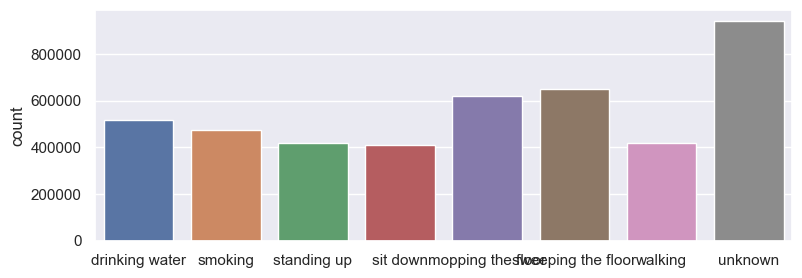

0: 11.57% [515171]
1: 10.69% [476211]
2:  9.42% [419371]
3:  9.24% [411331]
4: 13.88% [618251]
5: 14.62% [651251]
6:  9.44% [420431]
7: 21.14% [941591]

Classes [TRAIN]:


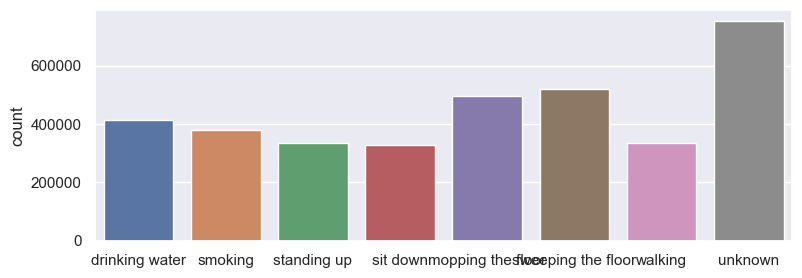


Classes [Valid]:


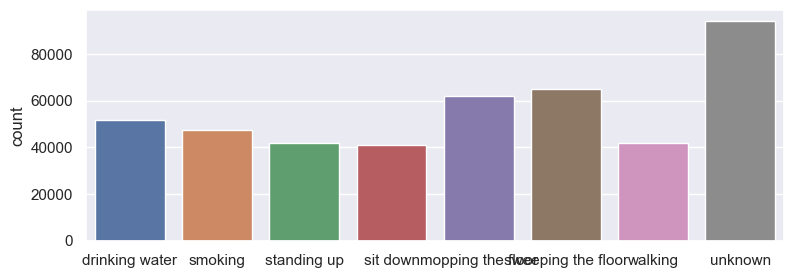


Classes [Test ]:


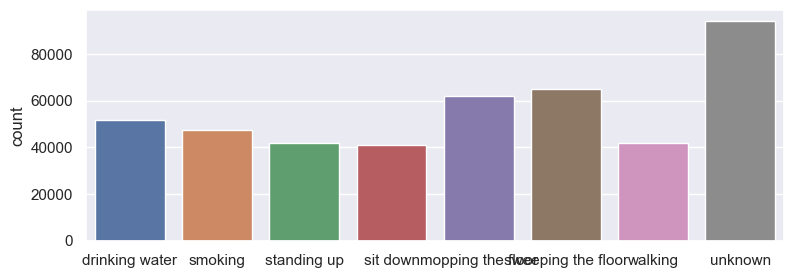

0: Train 11.57% [412137], Valid 11.57% [51517], Test 11.57% [51517]
1: Train 10.69% [380969], Valid 10.69% [47621], Test 10.69% [47621]
2: Train  9.42% [335497], Valid  9.42% [41937], Test  9.42% [41937]
3: Train  9.24% [329065], Valid  9.24% [41133], Test  9.24% [41133]
4: Train 13.88% [494601], Valid 13.88% [61825], Test 13.88% [61825]
5: Train 14.62% [521000], Valid 14.62% [65125], Test 14.62% [65126]
6: Train  9.44% [336345], Valid  9.44% [42043], Test  9.44% [42043]
7: Train 21.14% [753272], Valid 21.14% [94160], Test 21.14% [94159]

Done


In [28]:
############################
## Data Hyperparameters ####
Seed           = 42
T_Length       = 600
OffsetT        = 0
OffsetY        = 0
batch_size     = 500
TrainPerc      = 0.8
ValidPerc      = 0.1
TestPerc       = 1 - TrainPerc - ValidPerc
CustomNAString = None
#############################

########################
### Reading the Data ###
Classes = ['drinking water', 'smoking', 'standing up', 'sit down', 'mopping the floor', 'sweeping the floor', 'walking', 'unknown']
XY_DF = pd.read_csv(f"{path_data}/11-16 (1).csv", header = None).rename({0: "Target"}, axis = 1)
display(XY_DF) if isnotebook else print(XY_DF)
########################

####################
### Handling NAs ###
NBeforeCustomNADrop = None
DroppedCustomNARows = None
NBeforeNADrop = len(XY_DF)
XY_DF = XY_DF.dropna()
DroppedNARows = NBeforeNADrop - len(XY_DF)
if DroppedNARows > 0:
    print(f"Dropped NA rows count: {DroppedNARows} (out of {NBeforeNADrop})")

if CustomNAString is not None:
    NBeforeCustomNADrop = len(XY_DF)
    XY_DF = XY_DF.replace(CustomNAString, np.nan, regex = False).dropna()
    DroppedCustomNARows = NBeforeCustomNADrop - len(XY_DF)
    if DroppedCustomNARows > 0:
        print(f"Dropped custom NA rows count: {DroppedCustomNARows} (out of {NBeforeCustomNADrop})", )
if DroppedNARows > 0 or (DroppedCustomNARows is not None and DroppedCustomNARows > 0):
    print()
####################

###########################
### Melting the Dataset ###
#Getting a proper NxD matrix where N are the observations and D is the number of variables
#Melted_XY_DF = pd.melt(XY_DF, id_vars=["Target"], value_vars=np.arange(1200) + 1, var_name = "Timestamp", value_name = "Accelerometer")
Melted_XY_DF = []
for i in range(len(XY_DF)):
    tmpDF = pd.DataFrame({"Accelerometer": np.trim_zeros(XY_DF.iloc[i, np.arange(1200) + 1].values)})
    tmpDF["Target"] = XY_DF.iloc[i, 0]
    Melted_XY_DF.append(tmpDF[["Target", "Accelerometer"]])
Melted_XY_DF = pd.concat(Melted_XY_DF).reset_index(drop = True)
Melted_XY_DF
###########################

########################
### Scaling the Data ###
# scaler = LoadVariable(f"{SaveFolder}/scaler") #After loading a model with a different scaler we need to re-run this using the newly loaded scaler.
# print("\n\n\n!!!!!!!!!!!!\nDEBUGGING:\nScaling with SaveFolder scaler!!!\n!!!!!!!!!!!!\n\n\n")

# if os.path.exists(f"{path_models}/scaler"):
#     print("!!\n!! Using saved scaler.\n!!\n")
#     scaler = LoadVariable(f"{path_models}/scaler")
# else:
scaler = StandardScaler(with_mean = True, with_std = True).fit(Melted_XY_DF.iloc[:, 1:].values)
SaveVariable(scaler, f"{path_models}/scaler")

scaler_mean = scaler.mean_
scaler_sd = scaler.scale_
scaler_mean_sd = (scaler_mean, scaler_sd)

#Numpy takes care of the broadcasting automatically
Melted_XY_DF.iloc[:, 1:] = Scale(Melted_XY_DF.iloc[:, 1:].values, *scaler_mean_sd)
########################

############################
### Getting an X and a Y ###
XY_DFs = [y for x, y in Melted_XY_DF.groupby(["Target"])]
Xs_Data = [DF.iloc[:, 1: ].values.astype(np.float32) for DF in XY_DFs]
Ys_Data = [DF.iloc[:, 0:1].values.astype(int) - 1    for DF in XY_DFs]

Ls_Data  = [np.array([Classes[y] for y in CurYData.squeeze()]) for CurYData in Ys_Data]
############################

###########################################
# ### Transforming the data into NxTxD  ###
X_Data, Y_Data, L_Data = ListOf_NxD_to_N2xTxD(Xs_Data, Ls_Data, False, T_Length, ListOfY_Data = Ys_Data, TrainingMode = True, OffsetT = OffsetT, OffsetY = OffsetY, KeepUntilOffsetY = False)
###########################################

######################################
### Creating Train/Valid/Test sets ###
#==Stratified Split
TrainIndx, ValidIndx, TestIndx = train_valid_test_split(np.arange(X_Data.shape[0]), train_size = TrainPerc, valid_size = ValidPerc, Y_Data = None, random_state = Seed, shuffle = True, stratify = Y_Data)
X_Train      = X_Data[TrainIndx]
Y_Train      = Y_Data[TrainIndx]
Labels_Train = L_Data[TrainIndx]
X_Valid      = X_Data[ValidIndx]
Y_Valid      = Y_Data[ValidIndx]
Labels_Valid = L_Data[ValidIndx]
X_Test       = X_Data[TestIndx ]
Y_Test       = Y_Data[TestIndx ]
Labels_Test  = L_Data[TestIndx ]
######################################

###################################
### Creating Dataset/Dataloader ###
Dataset_Train = TensorDataset(torch.from_numpy(X_Train), torch.from_numpy(Y_Train))
Dataset_Valid = TensorDataset(torch.from_numpy(X_Valid), torch.from_numpy(Y_Valid))
Dataset_Test  = TensorDataset(torch.from_numpy(X_Test ), torch.from_numpy(Y_Test ))

Loader_Train = torch.utils.data.DataLoader(
    dataset = Dataset_Train,
    batch_size = batch_size,
    shuffle = True,
    pin_memory = True
    
)
Loader_Valid = torch.utils.data.DataLoader(
    dataset = Dataset_Valid,
    batch_size = batch_size,
    shuffle = False,
    pin_memory = True
)
Loader_Test = torch.utils.data.DataLoader(
    dataset = Dataset_Test,
    batch_size = batch_size,
    shuffle = False,
    pin_memory = True
)
###################################

##############################
### Extracting Information ###
O_Length, K_Length, N_Length, D_Length = Y_Train.shape[1], len(set(Y_Train.squeeze())) if len(Y_Train.squeeze().shape) == 1 else [len(set(Y_Train[:, i])) for i in range(Y_Train.shape[-1])], X_Train.shape[0], X_Train.shape[-1]
H1, W1 = T_Length, D_Length
print(f"X_Train.shape { X_Train.shape} {X_Train.dtype} | Y_Train.shape {Y_Train.shape} {Y_Train.dtype}")
print(f"X_Valid.shape { X_Valid.shape} {X_Valid.dtype} | Y_Valid.shape {Y_Valid.shape} {Y_Valid.dtype}")
print(f"X_Test .shape {  X_Test.shape} { X_Test.dtype} | Y_Test.shape  { Y_Test.shape} { Y_Test.dtype}")
print(f"X_Train: min = {X_Train.min():.4f}, max = {X_Train.max():.4f}")
print(f"X_Valid: min = {X_Valid.min():.4f}, max = {X_Valid.max():.4f}")
print(f"X_Test : min = { X_Test.min():.4f}, max = { X_Test.max():.4f}")
print(f"O_Length: {O_Length} K_Length: {K_Length}")
print(f"N_Length: {N_Length} H1: {H1} W1: {W1} D_Length: {D_Length}")

plt.rcParams['figure.figsize'] = [9, 3]
print(f"\nClasses:")
sns.countplot(x = [Classes[int(y)] for y in sorted(Y_Data.squeeze())])
plt.show()

CountData = sorted(Counter(Y_Data.squeeze()).items())
FreqKeys = [kv[0] for kv in CountData]
FreqData = np.array([kv[1] for kv in CountData]) / len(Y_Data) * 100
for i in range(len(FreqData)):
    print(f"{FreqKeys[i]}: {SpaceAString(f'{FreqData[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountData[i][1]}', MaxLength = 5)}]")

print(f"\nClasses [TRAIN]:")
sns.countplot(x = [Classes[int(y)] for y in sorted(Y_Train.squeeze())])
plt.show()

print(f"\nClasses [Valid]:")
sns.countplot(x = [Classes[int(y)] for y in sorted(Y_Valid.squeeze())])
plt.show()

print(f"\nClasses [Test ]:")
sns.countplot(x = [Classes[int(y)] for y in sorted(Y_Test.squeeze() )])
plt.show()
plt.rcParams['figure.figsize'] = OrigFigSize

CountTrain = sorted(Counter(Y_Train.squeeze()).items())
FreqTrain  = np.array([kv[1] for kv in CountTrain]) / len(Y_Train) * 100
CountValid = sorted(Counter(Y_Valid.squeeze()).items())
FreqValid  = np.array([kv[1] for kv in CountValid]) / len(Y_Valid) * 100
CountTest  = sorted(Counter(Y_Test.squeeze()).items())
FreqTest   = np.array([kv[1] for kv in CountTest ]) / len(Y_Test ) * 100

for i in range(len(FreqKeys)):
    print(f"{FreqKeys[i]}: Train {SpaceAString(f'{FreqTrain[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountTrain[i][1]}', MaxLength = 5)}], Valid {SpaceAString(f'{FreqValid[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountValid[i][1]}', MaxLength = 5)}], Test {SpaceAString(f'{FreqTest[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountTest[i][1]}', MaxLength = 5)}]")
##############################

print("\nDone")

# Neural Network

## Hyper Parameters

In [29]:
conv_input_size = (T_Length, D_Length)
input_size = np.prod(conv_input_size)
output_size = np.prod(O_Length)
print("conv_input_size: " + str(conv_input_size) + ", input_size: " + str(input_size) + ", D_Length: " + str(D_Length) + ", output_size: " + str(output_size))
hn1 = D_Length

ReluAlpha = 0
EluAlpha = 0

layer_type     = ['transfenc', 'dense', 'dense'] #Last layer is the output layer and always exists, no need to specify it here
transf_nhead   = [1     ]
transf_ff_dim  = [2048  ] #Transform D -> Hidden -> D
transf_l_norm  = [1e-5  ]
transf_drp     = [0.1   ]
transf_actv    = ["relu"]
###
NUM = 1
num_units  = [hn1, hn1, 256, 512]
num_units  = [num_units[0]] + [n_unit * NUM for n_unit in num_units[1:]]
activation = ["relu"] + ["relu"] * (len(layer_type)-1) #None, "relu6" "relu", "elu", "softplus", "tanh", "sigmoid"
dropout    = [0.1] * 1 + [0.1] * (len(layer_type)-1)
###
usebias = [True] * len(layer_type) + [True] #Length +1 because of the Output layer
###
l2_lamda = 0.05
mu = 0.99 #Momentum
###
conv_padding, conv_output_size = GetConvPaddingAndOutputSizes(T_Length, conv_input_size, input_size, layer_type, None, None, None, None, None, None, None, None, False, T_Length, D_Length, num_units, None)
print()
print("nPadding:", conv_padding)
print("X's Dims:", conv_output_size)
print("num_units", num_units)
print(f"\nbatch_size: {batch_size}")

assert len(num_units) == (len(layer_type) + 1), f"num_units should have a length of len(layer_type)+1"
lt = 0
if layer_type[lt] in ['transfenc', "customtransfenc"]:
    assert (num_units[lt] == num_units[lt + 1] if lt == 0 or (lt > 0 and bidir_rnns is None) or (lt > 0 and not bidir_rnns[lt-1]) else num_units[lt] * 2 == num_units[lt + 1]), f"lt: {lt}. Transformer encoder layer output shape must be the same as its input"
    assert num_units[lt] % transf_nhead[lt] == 0, f"lt: {lt}. embed_dim [{num_units[lt]}] must be divisible by num_heads [{transf_nhead[lt]}]"
for lt in range(len(layer_type) - 1):
    if layer_type[lt] in ['transfenc', "customtransfenc"]:
        assert (num_units[lt] == num_units[lt + 1] if lt == 0 or (lt > 0 and bidir_rnns is None) or (lt > 0 and not bidir_rnns[lt-1]) else num_units[lt] * 2 == num_units[lt + 1]), f"lt: {lt}. Transformer encoder layer output shape must be the same as its input"
        assert num_units[lt] % transf_nhead[lt] == 0, f"lt: {lt}. embed_dim [{num_units[lt]}] must be divisible by num_heads [{transf_nhead[lt]}]"

conv_input_size: (720, 1), input_size: 720, D_Length: 1, output_size: 1

nPadding: []
X's Dims: [720]
num_units [1, 1, 256, 512]

batch_size: 500


## Optimisation

### Structure

In [30]:
print(device)
Debug = False

model = Net(T_Length, K_Length, num_units, activation, usebias, dropout, EluAlpha, ReluAlpha, transf_nhead, transf_ff_dim, transf_l_norm, transf_drp, transf_actv)
# if device != "cpu":
#     model = nn.DataParallel(model)
print(model)

#Initialising the Metrics
train_losses, train_metric1s, train_metric2s, train_metric3s, valid_losses, valid_metric1s, valid_metric2s, valid_metric3s = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
train_best_loss, valid_best_loss, valid_best_metric1, valid_best_metric2, valid_best_metric3 = np.Inf, np.Inf, 0, np.nan, np.nan

cuda
Net(
  (layers): ModuleList(
    (0): Custom_Tranformer_Encoder(
      (layers): ModuleList(
        (0): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
        (1): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1, out_features=1, bias=True)
        )
        (2): Dropout(p=0.1, inplace=False)
        (3): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
        (4): Conv1d(720, 2048, kernel_size=(1,), stride=(1,))
        (5): ReLU()
        (6): Dropout(p=0.1, inplace=False)
        (7): Conv1d(2048, 720, kernel_size=(1,), stride=(1,))
      )
    )
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=720, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=8, bias=True)
  )
)


In [31]:
print("conv_input_size:", conv_input_size, "\n")
summary(model, input_size = [1, *conv_input_size], device = device, verbose = 1, col_names = ["kernel_size", "input_size", "output_size", "num_params", "mult_adds"], depth = 3)

if IS_GPU_AVAILABLE:
    torch.cuda.empty_cache()

conv_input_size: (720, 1) 

Layer (type:depth-idx)                                            Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
Net                                                               --                        --                        --                        --                        --
├─ModuleList: 1-1                                                 --                        --                        --                        --                        --
│    └─Custom_Tranformer_Encoder: 2-1                             --                        --                        --                        (recursive)               --
│    │    └─ModuleList: 3-1                                       --                        --                        --                        2,951,900                 --
│    └─Custom_Tranformer_Encoder: 2-2                             --                        [1, 720,

In [32]:
#Setting the Loss Function and Optimisation technique
criterion = nn.CrossEntropyLoss() #Using Categorical Cross Entropy loss function
print(criterion.__class__.__name__)
print("Multiclass Classification")

learning_rate = 1e-3
optimiser = torch.optim.AdamW(model.parameters(), lr = learning_rate, betas = (mu, 0.999), weight_decay = l2_lamda, amsgrad = False)

CrossEntropyLoss
Multiclass Classification


In [33]:
# for prm_grp in optimiser.param_groups:
#     prm_grp['lr'] = 1e-4
# #     prm_grp['weight_decay'] = 0.1

### Minibatch Gradient Descent (Numpy)

In [ ]:
Epochs = int(2)
PrintInfoEverynEpochs = 1
ShufflePerIteration = True
scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size = Epochs // 10 if Epochs > 10 else 3, gamma = 0.8)

valid_batch_size = None #None Y_Valid.shape[0]
#Each consecutive run returns its losses/Metrics and those get concatenated to the overall losses/metrics
new_train_losses, new_valid_losses, train_best_loss, valid_best_loss, new_train_metric1s, new_train_metric2s, new_train_metric3s, new_valid_metric1s, new_valid_metric2s, new_valid_metric3s,\
Metric1, Metric2, Metric3, valid_best_metric1, valid_best_metric2, valid_best_metric3, elapsed_time = \
    minibatch_gd(model, device, criterion, optimiser, scheduler, D_Length, X_Train, Y_Train, X_Valid, Y_Valid, epochs = Epochs, batch_size = batch_size,
                 ShufflePerIteration = ShufflePerIteration, PrintInfoEverynEpochs = PrintInfoEverynEpochs, train_best_loss = train_best_loss, test_best_loss = valid_best_loss,
                 BestMetric1 = valid_best_metric1, BestMetric2 = valid_best_metric2, BestMetric3 = valid_best_metric3, print_batch_num = True, Verbose = False,
                 test_batch_size = valid_batch_size)

train_losses, valid_losses = np.append(train_losses, new_train_losses), np.append(valid_losses, new_valid_losses)
train_metric1s, train_metric2s, train_metric3s = np.append(train_metric1s, new_train_metric1s), np.append(train_metric2s, new_train_metric2s), np.append(train_metric3s, new_train_metric3s)
valid_metric1s, valid_metric2s, valid_metric3s = np.append(valid_metric1s, new_valid_metric1s), np.append(valid_metric2s, new_valid_metric2s), np.append(valid_metric3s, new_valid_metric3s)
train_loss, valid_loss, valid_metric1, valid_metric2, valid_metric3 = LastNonNan(new_train_losses), LastNonNan(new_valid_losses), Metric1, Metric2, Metric3

print(f'\ntrain_best_loss: {train_best_loss:.5f}, valid_best_loss: {valid_best_loss:.5f}, "Acc": {valid_metric1:.5f}, "AUC": {valid_metric2:.5f}, "F1": {valid_metric3:.5f}')

if IS_GPU_AVAILABLE:
    torch.cuda.empty_cache()
if IsWindows:
    winsound.PlaySound('SystemExit', winsound.SND_NOSTOP)

### Stochastic Gradient Descent (Dataset)

In [ ]:
# Epochs = int(50)
# PrintInfoEverynEpochs = 1
# scheduler = None
# # scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size = Epochs // 10 if Epochs > 10 else 3, gamma = 0.8)

# new_train_losses, new_valid_losses, train_best_loss, valid_best_loss, new_train_metric1s, new_train_metric2s, new_train_metric3s, new_valid_metric1s, new_valid_metric2s, new_valid_metric3s,\
# Metric1, Metric2, Metric3, valid_best_metric1, valid_best_metric2, valid_best_metric3, elapsed_time = \
#     batch_gd(model, device, criterion, optimiser, scheduler, Loader_Train, Loader_Valid, epochs = Epochs, PrintInfoEverynEpochs = PrintInfoEverynEpochs,
#              train_best_loss = train_best_loss, test_best_loss = valid_best_loss, BestMetric1 = valid_best_metric1, BestMetric2 = valid_best_metric2, BestMetric3 = valid_best_metric3,
#              Verbose = False
#     )

# train_losses, valid_losses = np.append(train_losses, new_train_losses), np.append(valid_losses, new_valid_losses)
# train_metric1s, train_metric2s, train_metric3s = np.append(train_metric1s, new_train_metric1s), np.append(train_metric2s, new_train_metric2s), np.append(train_metric3s, new_train_metric3s)
# valid_metric1s, valid_metric2s, valid_metric3s = np.append(valid_metric1s, new_valid_metric1s), np.append(valid_metric2s, new_valid_metric2s), np.append(valid_metric3s, new_valid_metric3s)
# train_loss, valid_loss, valid_metric1, valid_metric2, valid_metric3 = LastNonNan(new_train_losses), LastNonNan(new_valid_losses), Metric1, Metric2, Metric3

# print(f'\ntrain_best_loss: {train_best_loss:.5f}, valid_best_loss: {valid_best_loss:.5f}, Acc: {valid_metric1:.5f}, AUC: {valid_metric2:.5f}, F1: {valid_metric3:.5f}')

# if IS_GPU_AVAILABLE:
#     torch.cuda.empty_cache()
# if IsWindows:
#     winsound.PlaySound('SystemExit', winsound.SND_NOSTOP)

In [150]:
# #Loading the best trained model (in case the last one was overfitted)
# model.load_state_dict(torch.load("model_dict.pt"))
# model.eval()
# train_loss = train_best_loss
# valid_loss = valid_best_loss
# valid_metric1 = valid_best_metric1
# valid_metric2 = valid_best_metric2
# valid_metric3 = valid_best_metric3

# Evaluation

## Training Metrics

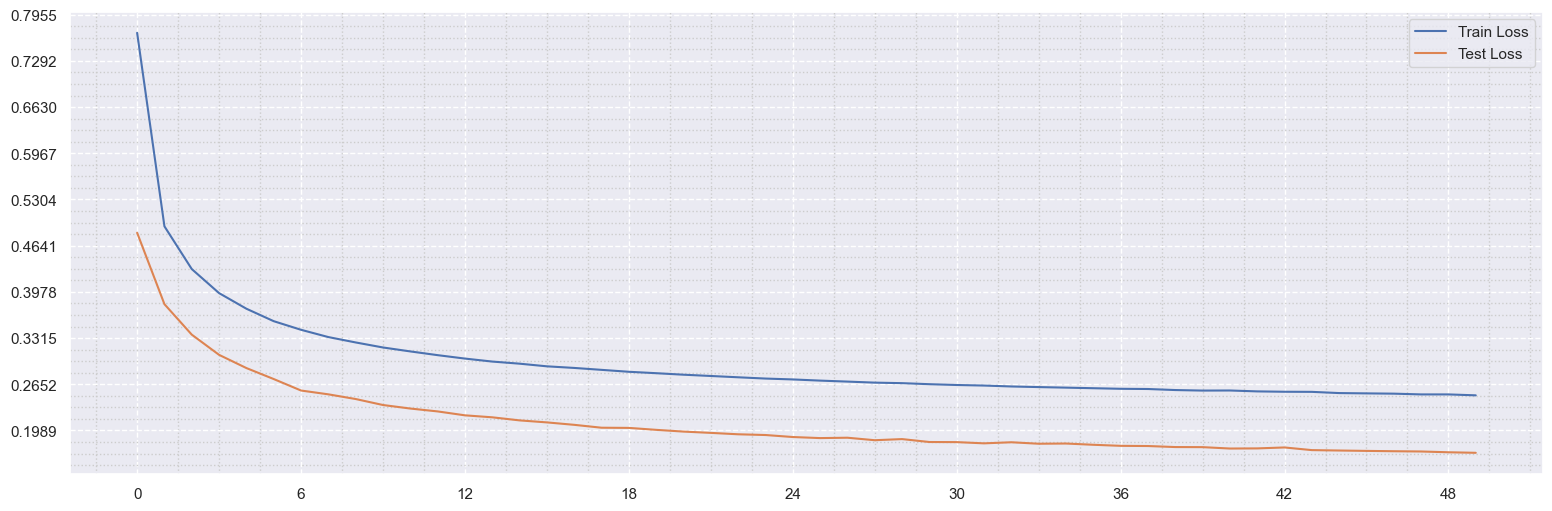

In [32]:
PlotHistory(train_losses[-(50):], valid_losses[-(50):], figsize=(19, 6), test_alpha = 1)

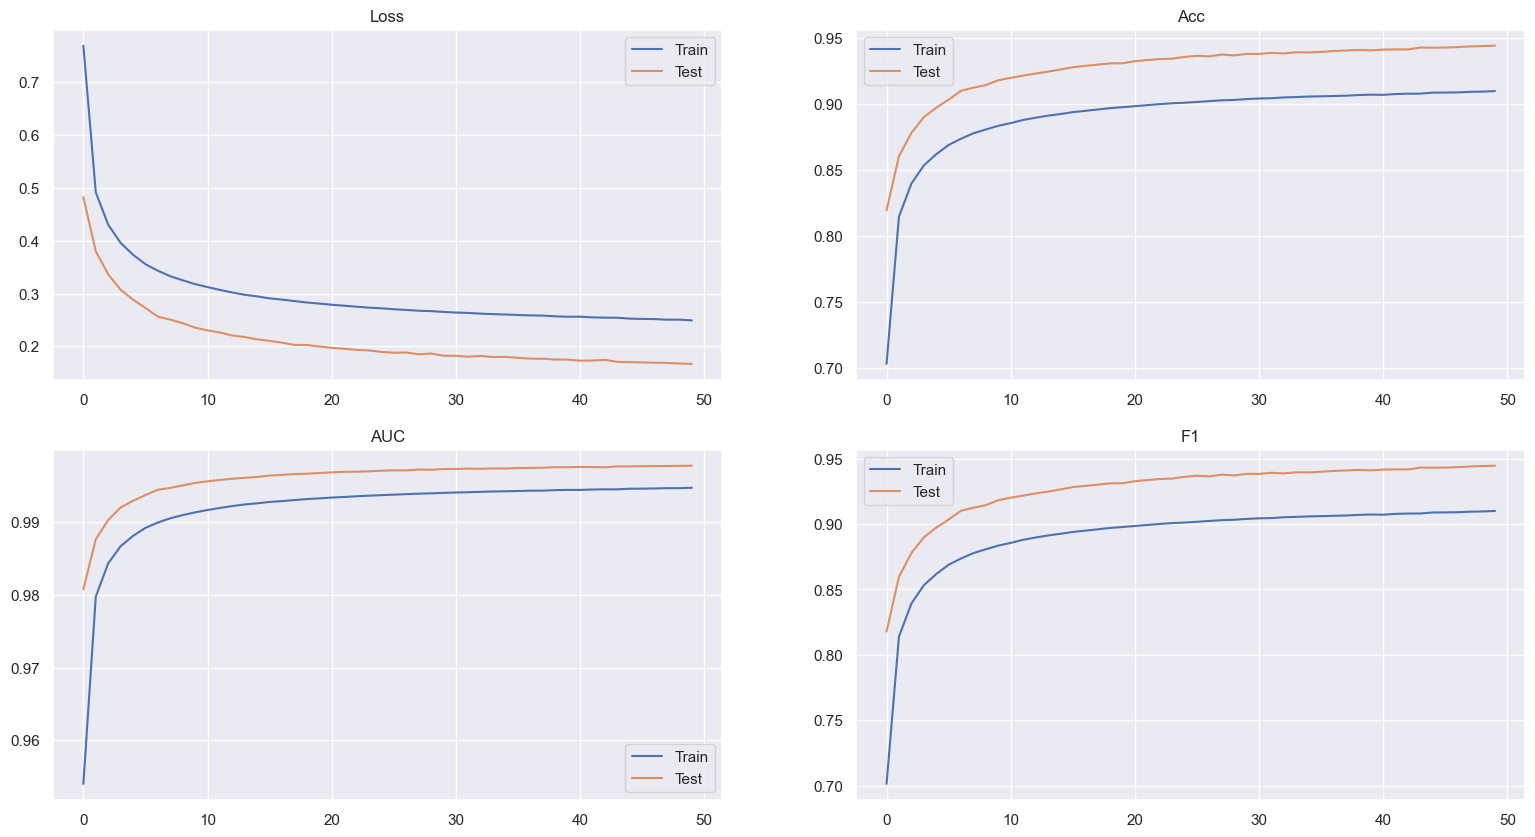

In [33]:
PlotAllMetrics(["Loss", "Acc", "AUC", "F1"],
               [train_losses, train_metric1s, train_metric2s, train_metric3s],
               TestMetrics = [valid_losses, valid_metric1s, valid_metric2s, valid_metric3s],
               figsize = [19, 10], test_alpha = 0.90)

## Multiclass Classification

#batches: 891.


Sample-wise Acc: 94.40%, AUC: 1.00, F1: 0.94
Class-wise  Acc: 98.60%, Recall: 0.944, Precision: 0.944

Confusion matrix
[[48290  2653    88    80    52    38     8   308]
 [ 1772 43789   417   456    65    13   131   978]
 [   39   867 39436   580   133    24   136   722]
 [  109   704   418 38978   113    10    59   742]
 [   65   388   266   282 57270  2453   721   380]
 [   58   172    68   201  2568 61253   522   284]
 [    1   333   137    94   503   236 40655    84]
 [  738   859   763   912    93    26    23 90745]]


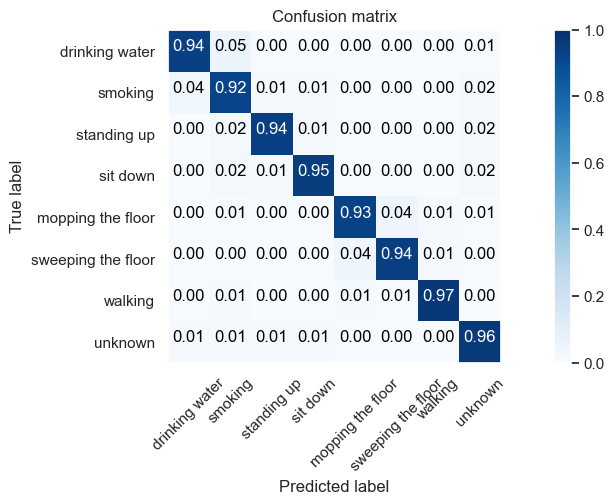


Class     drinking water. Acc: 0.987, Recall: 0.937, Precision: 0.946, F1: 0.941
Class            smoking. Acc: 0.978, Recall: 0.920, Precision: 0.880, F1: 0.899
Class        standing up. Acc: 0.990, Recall: 0.940, Precision: 0.948, F1: 0.944
Class           sit down. Acc: 0.989, Recall: 0.948, Precision: 0.937, F1: 0.942
Class  mopping the floor. Acc: 0.982, Recall: 0.926, Precision: 0.942, F1: 0.934
Class sweeping the floor. Acc: 0.985, Recall: 0.941, Precision: 0.956, F1: 0.948
Class            walking. Acc: 0.993, Recall: 0.967, Precision: 0.962, F1: 0.965
Class            unknown. Acc: 0.984, Recall: 0.964, Precision: 0.963, F1: 0.963

Per Class Metrics:


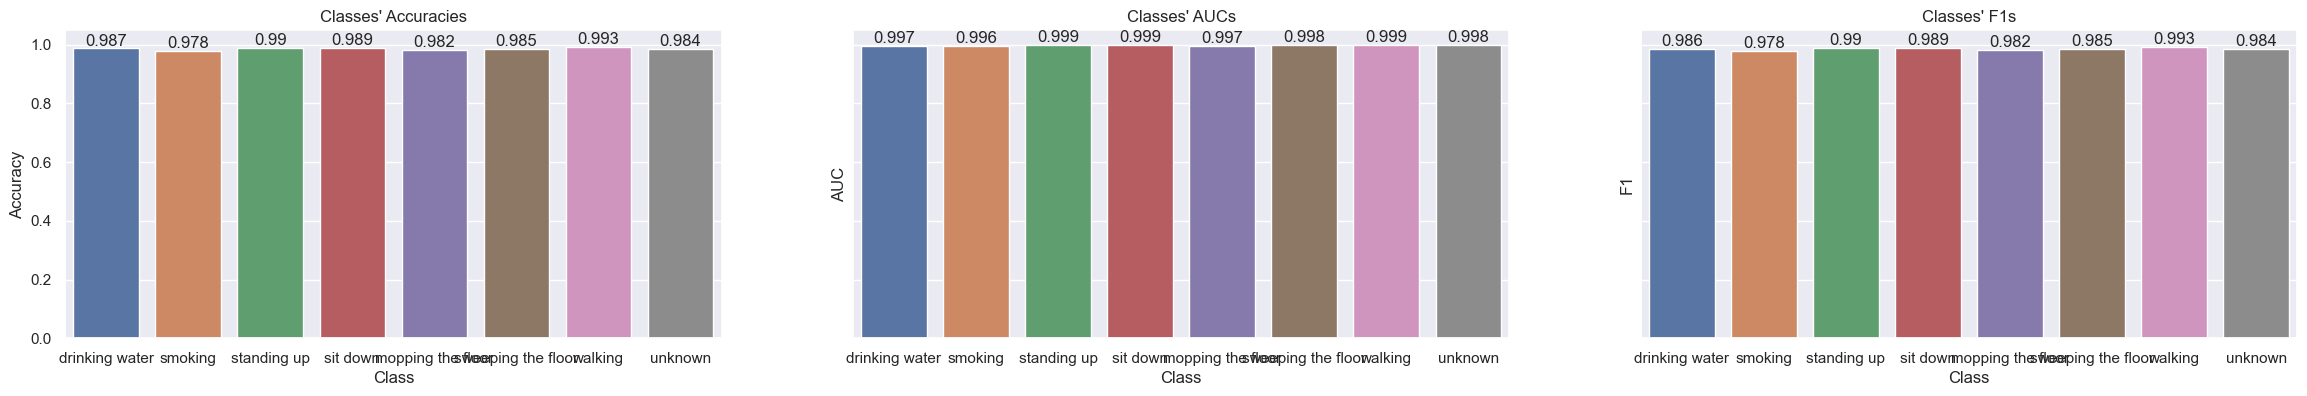


Per Class ROC:


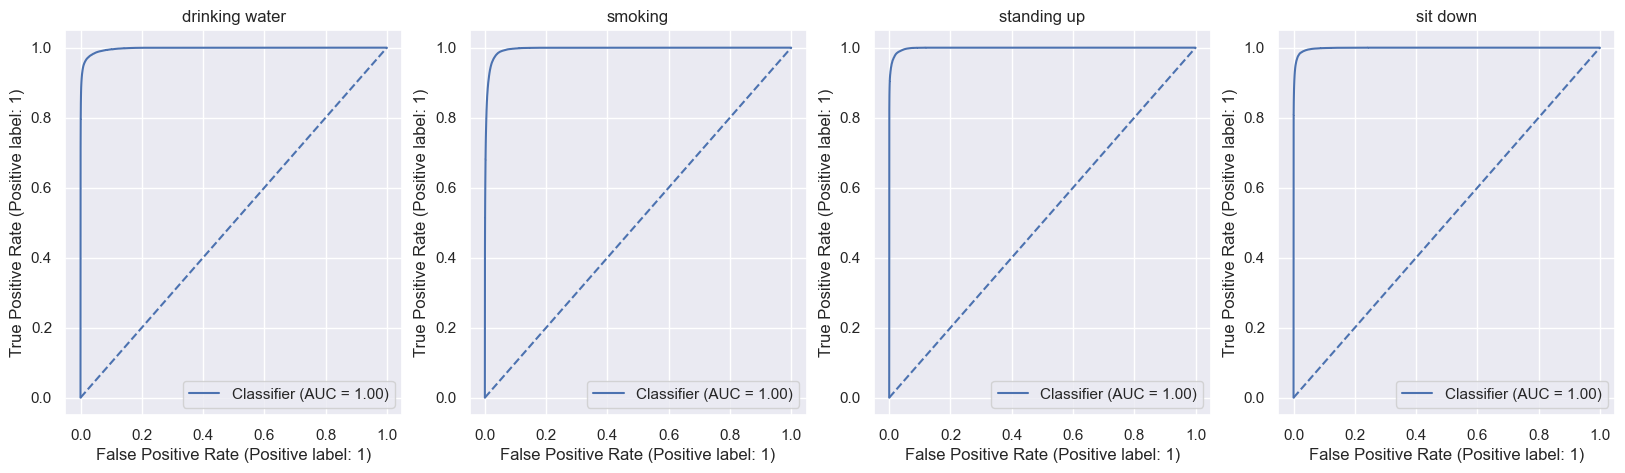


Per Class Precision-Recall Curve:


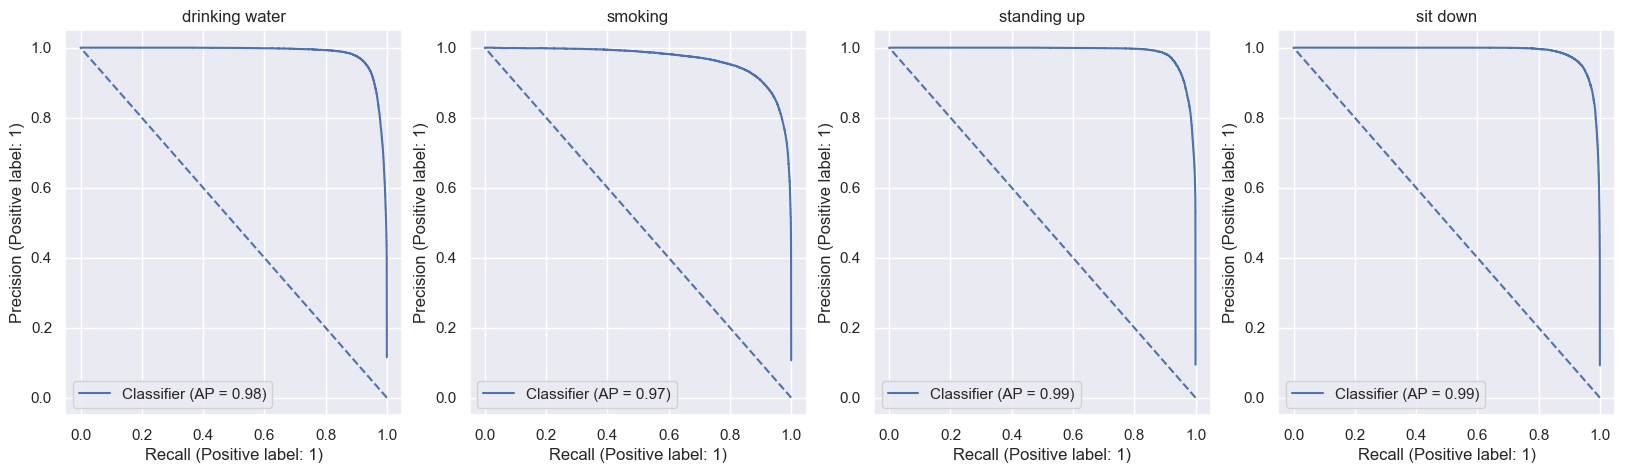

In [33]:
Labels = Classes
test_batch_size = 500
MaxLabelsLen = max([len(lbl) for lbl in Labels])
with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
        model.eval() #Putting model in evaluation mode so that things like dropout() are deactivated
        model.to(device) #Moving the model to the appropriate device (CPU/CUDA/etc.)
        
        #Using the Forward direction of the model to get the Predictions (also returning the corresponding Targets in case there's suffling and X_Test isn't indexed the same)
        Preds_prob, Preds, Targets = EvalPredict(model, test_batch_size, device, X_Test, Y_Test)

test_Acc, test_AUC, test_F1 = GetCategoricalMetrics(Preds_prob, Preds, Targets)
print(f'Sample-wise Acc: {test_Acc * 100:.2f}%, AUC: {test_AUC:.2f}, F1: {test_F1:.2f}')
print(f"Class-wise  Acc: {ClassAccMulti(Targets, Preds, K_Length) * 100:.2f}%, Recall: {recall_score(Targets, Preds, average = 'weighted'):.3f}, Precision: {precision_score(Targets, Preds, average = 'weighted'):.3f}\n") #'micro', 'macro', 'weighted', 'samples'

#Viewing the overall Categorical metrics and Plotting the Confusion Matrix
PlotCategoricalMetrics(Preds, Targets, Labels, normalise = True, figsize = [11, 5])
print("")

plt.rcParams['figure.figsize'] = [5, 5]
TrueClasses, PerClassAccuracy, PerClassAUC, PerClassF1 = [], [], [], []
for k in range(K_Length):
    PredClass = Preds.squeeze()   == k
    TrueClass = Targets.squeeze() == k
    TrueClasses.append(TrueClass)
    cur_test_Acc, cur_test_AUC, cur_test_F1 = GetCategoricalMetrics(Preds_prob[:, k], PredClass, TrueClass)
    PerClassAccuracy.append(cur_test_Acc)
    PerClassAUC.append(cur_test_AUC)
    PerClassF1.append(cur_test_F1)
    print(f"Class {SpaceAString(Labels[k], MaxLabelsLen)}. Acc: {np.mean(TrueClass == PredClass):.3f}, Recall: {recall_score(TrueClass, PredClass):.3f}, Precision: {precision_score(TrueClass, PredClass):.3f}, F1: {f1_score(TrueClass, PredClass):.3f}")
PerClassAccuracy, PerClassAUC, PerClassF1 = np.array(PerClassAccuracy), np.array(PerClassAUC), np.array(PerClassF1)

print("\nPer Class Metrics:")
PlotPerClassMetrics(K_Length, PerClassAccuracy, PerClassAUC, PerClassF1, Labels = Labels)

print("\nPer Class ROC:")
PlotPerClassROCCurve(K_Length, TrueClasses, Preds_prob, Labels = Labels)

print("\nPer Class Precision-Recall Curve:")
PlotPerClassPRCurve(K_Length, TrueClasses, Preds_prob, Labels = Labels)

plt.rcParams['figure.figsize'] = OrigFigSize

In [ ]:
# Labels = Classes
# with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
#         model.eval() #Putting model in evaluation mode so that things like dropout() are deactivated
#         model.to(device) #Moving the model to the appropriate device (CPU/CUDA/etc.)
        
#         #Using the Forward direction of the model to get the Predictions (also returning the corresponding Targets in case there's suffling and X_Test isn't indexed the same)
#         Preds_prob, Preds, Targets = EvalPredict(model, device, Loader_Test)

# test_Acc, test_AUC, test_F1 = GetCategoricalMetrics(Preds_prob, Preds, Targets)
# print(f'Sample-wise Acc: {test_Acc * 100:.2f}%, AUC: {test_AUC:.2f}, F1: {test_F1:.2f}')
# print(f"Class-wise  Acc: {ClassAccMulti(Targets, Preds, K_Length) * 100:.2f}%, Recall: {recall_score(Targets, Preds, average = 'weighted'):.3f}, Precision: {precision_score(Targets, Preds, average = 'weighted'):.3f}\n") #'micro', 'macro', 'weighted', 'samples'

# #Viewing the overall Categorical metrics and Plotting the Confusion Matrix
# PlotCategoricalMetrics(Preds, Targets, Labels, normalise = True, figsize = [11, 5])
# print("")

# plt.rcParams['figure.figsize'] = [5, 5]
# TrueClasses, PerClassAccuracy, PerClassAUC, PerClassF1 = [], [], [], []
# for k in range(K_Length):
#     PredClass = Preds.squeeze()   == k
#     TrueClass = Targets.squeeze() == k
#     TrueClasses.append(TrueClass)
#     cur_test_Acc, cur_test_AUC, cur_test_F1 = GetCategoricalMetrics(Preds_prob[:, k], PredClass, TrueClass)
#     PerClassAccuracy.append(cur_test_Acc)
#     PerClassAUC.append(cur_test_AUC)
#     PerClassF1.append(cur_test_F1)
#     print(f"Class {SpaceAString(Labels[k], MaxLabelsLen)}. Acc: {np.mean(TrueClass == PredClass):.3f}, Recall: {recall_score(TrueClass, PredClass):.3f}, Precision: {precision_score(TrueClass, PredClass):.3f}, F1: {f1_score(TrueClass, PredClass):.3f}")
# PerClassAccuracy, PerClassAUC, PerClassF1 = np.array(PerClassAccuracy), np.array(PerClassAUC), np.array(PerClassF1)

# print("\nPer Class Metrics:")
# PlotPerClassMetrics(K_Length, PerClassAccuracy, PerClassAUC, PerClassF1, Labels = Labels)

# print("\nPer Class ROC:")
# PlotPerClassROCCurve(K_Length, TrueClasses, Preds_prob, Labels = Labels)

# print("\nPer Class Precision-Recall Curve:")
# PlotPerClassPRCurve(K_Length, TrueClasses, Preds_prob, Labels = Labels)

# plt.rcParams['figure.figsize'] = OrigFigSize

# Saving the Model

In [ ]:
print("path_root:", path_root, "\n")

SaveFolder = (f'{path_root}/Models/' +
              f'{datetime.now(timezone("Europe/Athens")).strftime("%Y-%m-%d %H-%M")}' +
              f", T-{T_Length} Valid Loss {valid_loss:.2f}" +
              f' Acc {valid_metric1:.2f}' +
              f', Test Acc {test_Acc:.2f}' +
              f' AUC {test_AUC:.2f}' +
              f' F1 {test_F1:.2f}'
)
print(SaveFolder)
os.makedirs(SaveFolder, exist_ok = True)

In [34]:
if isnotebook:
    i = 2

In [ ]:
if isnotebook:
    i += 1
    print(i)
    display(_ih[i])

In [36]:
if isnotebook:
    PossibleNetClass = _ih[i]

In [36]:
### Saving the Model ###
QuoteIfNone = lambda x: f"'{x}'" if x is not None else "None"

#Saving the Parameters
WriteText(
    f"#PyTorch v{torch.__version__}\n#CUDA device available: {IS_GPU_AVAILABLE}\n{f'#{torch.cuda.device_count()} devices available' if torch.cuda.is_available() else ''}\n#device = {device}\n" +
    f"#isnotebook = {isnotebook}\n#isgooglecolab = {isgooglecolab}\n#shell = {shell}\n\n" +
    f"layer_type = {json.dumps(layer_type)}\nSeed = {Seed}\nnum_units = {json.dumps(num_units)}\nactivation = {json.dumps(activation)}\ndropout = {json.dumps(dropout)}\nusebias = {usebias}\n" +
    f"batch_size = {batch_size}\n" +
    f"T_Length = {T_Length}\nK_Length = {K_Length}\nD_Length = {D_Length}\nH1 = {H1}\nW1 = {W1}\nconv_input_size = {conv_input_size}\ninput_size = {input_size}\noutput_size = {output_size}\nhn1 = {hn1}\n\n" +
    f"transf_nhead = {transf_nhead}\ntransf_ff_dim = {transf_ff_dim}\ntransf_l_norm = {transf_l_norm}\ntransf_drp = {transf_drp}\ntransf_actv = {transf_actv}\n" +
    f"l2_lamda = {l2_lamda}\nmu = {mu}\n" +
    f"\nPrintInfoEverynEpochs = {PrintInfoEverynEpochs}\n" +
    f"\ntrain_best_loss = {train_best_loss}\nvalid_best_loss = {valid_best_loss}\nReluAlpha = {ReluAlpha}\nEluAlpha = {EluAlpha}\n" +
    f"valid_metric1 = {valid_metric1}\nvalid_metric2 = {valid_metric2}\nvalid_metric3 = {valid_metric3}\n"
    f"valid_best_metric1 = {valid_best_metric1}\nvalid_best_metric2 = {valid_best_metric2}\nvalid_best_metric3 = {valid_best_metric3}\n",
f"{SaveFolder}/Parameters.py")

#Saving the Losses so we can plot them in the future
WriteText(json.dumps(train_losses.tolist())  , f"{SaveFolder}/Metrics/train_losses.json"  )
WriteText(json.dumps(valid_losses.tolist())  , f"{SaveFolder}/Metrics/valid_losses.json"  )
WriteText(json.dumps(train_metric1s.tolist()), f"{SaveFolder}/Metrics/train_metric1s.json")
WriteText(json.dumps(train_metric2s.tolist()), f"{SaveFolder}/Metrics/train_metric2s.json")
WriteText(json.dumps(train_metric3s.tolist()), f"{SaveFolder}/Metrics/train_metric3s.json")
WriteText(json.dumps(valid_metric1s.tolist()), f"{SaveFolder}/Metrics/valid_metric1s.json")
WriteText(json.dumps(valid_metric2s.tolist()), f"{SaveFolder}/Metrics/valid_metric2s.json")
WriteText(json.dumps(valid_metric3s.tolist()), f"{SaveFolder}/Metrics/valid_metric3s.json")

#Saving the Optimiser
WriteText(optimiser, f"{SaveFolder}/Optimiser.txt")
#Saving the optimiser's parameters
torch.save(optimiser.state_dict(), f"{SaveFolder}/optimiser_dict.pt")

#Saving the Criterion
SaveVariable(criterion, f"{SaveFolder}/criterion.pt")
#Saving the Criterion's name (easier to see by looking at the file)
WriteText(criterion, f"{SaveFolder}/criterion.txt")

#Saving the Net() Class
if isnotebook:
    print(PossibleNetClass.partition('\n')[0])
    WriteText(PossibleNetClass, f"{SaveFolder}/Net.py")
else:
    WriteText(f"#Net() not found.\n#Probably not a notebook?\n", f"{SaveFolder}/Net.py")

#Saving the Scaler Variable
SaveVariable(scaler, f"{SaveFolder}/scaler")
#Saving the Scaler's parameters as text
WriteText(scaler_mean.tolist(), f"{SaveFolder}/scaler_mean.json")
WriteText(scaler_sd.tolist(), f"{SaveFolder}/scaler_std.json")

#Saving Model itself
torch.save(model.state_dict(), f"{SaveFolder}/model_dict.pt")
#Saving Model itself
SaveVariableDill(model, f"{SaveFolder}/model.pt")

#Saving the Scheduler
SaveVariableDill(scheduler, f"{SaveFolder}/scheduler.pt")
print("Done!")

Done!


# Loading the Model

In [28]:
SaveFolder = f"{path_root}/Models/T-600 Valid Loss 0.17 Acc 0.94, Test Acc 0.94 AUC 1.00 F1 0.94"

In [29]:
# PrevT_Length = T_Length
# PrevTrainPerc = TrainPerc
# PrevValidPerc = ValidPerc
#Loading the Parameters
exec(ReadText(f"{SaveFolder}/Parameters.py"))
# if PrevT_Length != T_Length:
#     warnings.warn(f"PrevT_Length: {PrevT_Length}, whilst now after loading, T_Length: {T_Length}. Re-run the DATA section!")
# if PrevTrainPerc != TrainPerc:
#     warnings.warn(f"PrevTrainPerc: {PrevTrainPerc}, whilst now after loading, TrainPerc: {TrainPerc}. Re-run the DATA section!")
# if PrevValidPerc != ValidPerc:
#     warnings.warn(f"PrevValidPerc: {PrevValidPerc}, whilst now after loading, ValidPerc: {ValidPerc}. Re-run the DATA section!")

#Loading the Criterion
criterion = LoadVariable(f"{SaveFolder}/criterion.pt")

#Loading Model itself
model = LoadVariableDill(f"{SaveFolder}/model.pt").to(device)
model.eval() #Putting model in evaluation mode so that things like dropout() are deactivated

#Loading the Optimiser
optimiser = torch.optim.AdamW(model.parameters(), lr = 0.1, betas = (0.9, 0.9), weight_decay = 0, amsgrad = False)
optimiser.load_state_dict(torch.load(f"{SaveFolder}/optimiser_dict.pt"))

#Loading the Scheduler
scheduler = LoadVariableDill(f"{SaveFolder}/scheduler.pt")

#Loading the Scaler
print("!!! Be EXTRA careful when loading a scaler as it might be different to the one used in the beginning under 'Data' to scale current X_Test, and if so, re-run 'Data' with its scaler loading commented off !!!")
scaler = LoadVariable(f"{SaveFolder}/scaler")
scaler_mean = np.array(json.loads(ReadText(f"{SaveFolder}/scaler_mean.json"))) if os.path.exists(f"{SaveFolder}/scaler_mean.json") else scaler.mean_
scaler_sd = np.array(json.loads(ReadText(f"{SaveFolder}/scaler_std.json"))) if os.path.exists(f"{SaveFolder}/scaler_std.json") else scaler.scale_
scaler_mean_sd = (scaler_mean, scaler_sd)

print("Done!")

!!! Be EXTRA careful when loading a scaler as it might be different to the one used in the beginning under 'Data' to scale current X_Test, and if so, re-run 'Data' with its scaler loading commented off !!!
Done!


In [30]:
train_losses   = np.array(json.loads(ReadText(f"{SaveFolder}/Metrics/train_losses.json")))
valid_losses   = np.array(json.loads(ReadText(f"{SaveFolder}/Metrics/valid_losses.json")))
train_metric1s = np.array(json.loads(ReadText(f"{SaveFolder}/Metrics/train_metric1s.json")))
train_metric2s = np.array(json.loads(ReadText(f"{SaveFolder}/Metrics/train_metric2s.json")))
train_metric3s = np.array(json.loads(ReadText(f"{SaveFolder}/Metrics/train_metric3s.json")))
valid_metric1s = np.array(json.loads(ReadText(f"{SaveFolder}/Metrics/valid_metric1s.json")))
valid_metric2s = np.array(json.loads(ReadText(f"{SaveFolder}/Metrics/valid_metric2s.json")))
valid_metric3s = np.array(json.loads(ReadText(f"{SaveFolder}/Metrics/valid_metric3s.json")))
print("Done!")

Done!


In [31]:
model = Net(T_Length, K_Length, num_units, activation, usebias, dropout, EluAlpha, ReluAlpha, transf_nhead, transf_ff_dim, transf_l_norm, transf_drp, transf_actv)

if device != "cpu":
    model = nn.DataParallel(model)
    model.load_state_dict(torch.load(f"{SaveFolder}/model_dict.pt"))
else:
    model.load_state_dict(torch.load(f"{SaveFolder}/model_dict.pt", map_location = torch.device("cpu")))

#model.load_state_dict(OrderedDict((k.replace("module.", ""), v) for k, v in torch.load(f"{SaveFolder}/model_dict.pt", map_location = "cpu").items())) #De-DataParallel the model
model.eval()
print("Done!")

Done!


# Predicting on External Data

In [33]:
External_DF = pd.read_csv(f"{path_data}/11-16 (1).csv", header = None).iloc[:, 1:]
Melted_External_DF = []
for i in range(len(External_DF)):
    tmpDF = pd.DataFrame({"Accelerometer": np.trim_zeros(External_DF.iloc[i, :].values)})
    Melted_External_DF.append(tmpDF[["Accelerometer"]])
Melted_External_DF = pd.concat(Melted_External_DF).reset_index(drop = True)
Melted_External_DF
X_External = Scale(Melted_External_DF.values, *scaler_mean_sd)
X_External = NxD_to_N2xTxD(X_External, None, T_Length, Y_Data = None, TrainingMode = False, OffsetT = 0, OffsetY = 0, KeepUntilOffsetY = False)

MYDataset = TensorDataset(torch.from_numpy(X_External.copy()))
MYDataLoader = torch.utils.data.DataLoader(
    MYDataset,
    batch_size = batch_size,
    pin_memory = True
)

model.to(device)
model.eval()
with torch.no_grad():
    TestPredictions = []
    for inputs in tqdm(MYDataLoader, initial = 0, total = len(MYDataLoader), leave = False):
        TestPredictions.append(model(inputs[0].to(device)))
    _, TestPredictions = torch.max(nn.Softmax(dim = 1)(torch.cat(TestPredictions)), 1)
    TestPredictions += 1
    TestResults = pd.DataFrame(TestPredictions.cpu().numpy()).reset_index()
    TestResults.columns = ["Id", "Class"]

FileExportPath = f"{path_root}/Exports/Results.csv"
TestResults.to_csv(FileExportPath, sep = ',', header = True, index = False)
print(f"Results saved on: {FileExportPath}")

TestResults

Results saved on: D:\GiannisM\Downloads\Exercises\Fiver\100. frotribe FFNN Multiclass Classification/Exports/Results.csv


,Id,Class
0,0,1
1,1,1
2,2,1
3,3,1
4,4,5
...,...,...
4457676,4457676,8
4457677,4457677,8
4457678,4457678,8
4457679,4457679,8
